## Dynamic traffic control using RL

Name: Aditi Pawar ,Shreyas Sawant, Utkarsh Rawat

Roll no.: I004, I059, I069

B Tech AI

## =======================================================================================

🔗 Reference Video: [YouTube Link](https://www.youtube.com/watch?v=NOPn9sE0AdY)

### **Map Setup Instructions**

1. **Export OSM File**

   * Open *OpenStreetMap* → Select desired region → Export as **map.osm**

2. **Copy Typemap File**

   * Copy `osmNetconvert.typ.xml` from:

     ```
     C:\Program Files (x86)\Eclipse\Sumo\data\typemap
     ```

     into your working folder.

3. **Generate Network File**

   * Run in Command Prompt:

     ```bash
     netconvert --osm-files map.osm -o test.net.xml -t osmNetconvert.typ.xml --xml-validation never
     ```

4. **Import Additional Polygons**

   * Visit: [SUMO Wiki – OSM Import](https://sumo.dlr.de/wiki/Networks/Import/OpenStreetMap)
   * Copy the polygon code provided → Save as **typemap.xml** in the working folder.

5. **Convert Polygons**

   * Run in Command Prompt:

     ```bash
     polyconvert --net-file test.net.xml --osm-files map.osm --type-file typemap.xml -o map.poly.xml --xml-validation never
     ```

6. **Copy Random Trips Script**

   * Copy `randomTrips.py` from:

     ```
     C:\Program Files (x86)\Eclipse\Sumo\tools
     ```

     into your working folder.

7. **Generate Random Trips**

   * Run in Command Prompt:

     ```bash
     python randomTrips.py -n test.net.xml -r map.rou.xml -e 1000 -l --validate
     ```

8. **Create Simulation Config File** (`map.sumo.cfg`)

   * Include the following entries:

     ```xml
     <net-file value="test.net.xml"/>
     <route-files value="map.rou.xml"/>
     <additional-files value="map.poly.xml"/>
     ```

---


## =======================================================================================

# Methods Used

---

## 1. DQN (Deep Q-Network)

### How it works
- **Core Idea:** DQN is a **value-based** reinforcement learning method. It estimates the action-value function \( Q(s, a) \), which represents the expected return (cumulative reward) of taking action \(a\) in state \(s\).
- **Neural Network Approximation:** Instead of storing a huge Q-table, DQN uses a neural network to approximate Q-values for all possible actions given a state.
- **Exploration vs. Exploitation:** Uses **ε-greedy strategy** – with probability ε, take a random action (exploration); otherwise, pick the action with the highest Q-value (exploitation).
- **Experience Replay:** Transitions \((s, a, r, s')\) are stored in a buffer, and random batches are sampled for training. This breaks correlation between consecutive samples and stabilizes training.
- **Fixed Target Network:** To avoid instability, DQN uses a frozen copy of the Q-network (target network) that is updated periodically.

### Key components in this project
- `DQNModel`: Neural network that outputs Q-values for each action.
- `store_transition()`: Saves experiences into replay memory.
- `learn()`: Samples batches, computes **temporal-difference (TD) error**:  
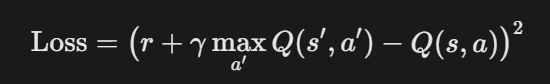
- `choose_action()`: Selects actions using ε-greedy.

### In traffic control
- **State:** Number of vehicles per lane at a junction.  
- **Actions:** Which traffic light phase to activate.  
- **Reward:** Negative waiting time (penalizes congestion).  

DQN works well for small action spaces, but training can be unstable in complex traffic networks.

---

## 2. PPO (Proximal Policy Optimization)

### How it works
- **Core Idea:** PPO is a **policy-based** RL method. Instead of learning Q-values, it directly learns a policy \( \pi(a|s) \), which gives the probability of choosing each action.
- **Actor-Critic Architecture:**  
  - **Actor:** Learns the policy (action distribution).  
  - **Critic:** Learns the value function \( V(s) \), which predicts expected return from a state.  
- **Stability via Clipping:** PPO avoids large, unstable updates by clipping the policy ratio:  
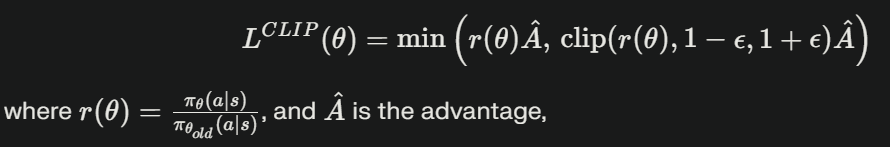
- **Advantage Estimation:** Uses **Generalized Advantage Estimation (GAE)** to reduce variance in updates.

### Key components
- `PPOModel`: Separate actor and critic networks.
- `choose_action()`: Samples actions from the learned probability distribution.
- `store_transition()`: Records states, actions, rewards, values, and log probabilities.
- `learn()`: Computes advantages and updates policy using the clipped objective.

### In traffic control
- Learns **smooth policies** for traffic light switching.  
- Balances exploration and exploitation via action probabilities.  
- Critic ensures stable learning by guiding the policy with value estimates.  

PPO is highly stable and scales well, making it excellent for real-world-like traffic control tasks.

---

## 3. A2C (Advantage Actor-Critic)

### How it works
- **Core Idea:** A2C is also a **policy-based** method, similar to PPO but simpler. It combines value function learning with policy learning.
- **Architecture:** A single neural network with shared layers and two heads:  
  - **Actor head:** Outputs policy probabilities.  
  - **Critic head:** Outputs state values \( V(s) \).  
- **Advantage Function:** Instead of directly using returns, A2C uses:  
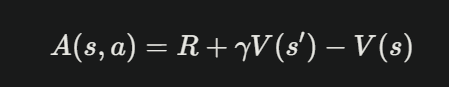
  to reduce variance in updates.
- **Synchronous Updates:** Usually run across multiple parallel environments to stabilize updates (though in this project it runs sequentially).

### Key components
- `A2CModel`: Neural network with actor and critic outputs.  
- `choose_action()`: Samples actions from policy distribution.  
- `learn()`: Computes advantages and updates actor and critic simultaneously.  

### In traffic control
- Efficiently learns traffic light switching policies.  
- Less stable than PPO but lighter in computation.  
- Performs well when the environment is not extremely stochastic.

---

## 4. SARSA (State-Action-Reward-State-Action)

### How it works
- **Core Idea:** SARSA is a **tabular, on-policy** RL algorithm.  
- **Q-table:** Stores Q-values for each \((s, a)\) pair explicitly.  
- **Update Rule:**  
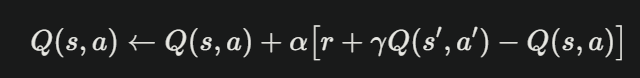
  
  Unlike Q-learning, SARSA updates using the action actually taken (on-policy).  
- **Exploration:** ε-greedy action selection.  

### Key components
- `q_tables`: Lookup tables for each junction.  
- `get_state_index()`: Maps states to indices (limited to 10,000 states here).  
- `learn()`: Updates Q-values based on SARSA update.  
- `choose_action()`: ε-greedy selection.  

### In traffic control
- Works only for **small state spaces**.  
- Becomes impractical when states (e.g., vehicle counts per lane) grow large.  
- Useful as a **baseline** for comparison with neural network methods.

---

## 📊 Comparison Table

| Method | Type          | Approach                       | Scalability | Stability |
|--------|--------------|--------------------------------|-------------|-----------|
| DQN    | Value-based   | Learns Q-function              | Good        | Medium    |
| PPO    | Policy-based  | Direct policy optimization     | Excellent   | High      |
| A2C    | Policy-based  | Advantage-based policy updates | Good        | Medium    |
| SARSA  | Tabular       | On-policy Q-learning           | Poor        | Low       |

---



## =======================================================================================

## CODE : 

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import os
import sys
import time
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque
import json
import pickle
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

# SUMO TraCI setup
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    if tools not in sys.path:
        sys.path.append(tools)
else:
    raise EnvironmentError("please declare environment variable 'SUMO_HOME'")

from sumolib import checkBinary
import traci

In [2]:
# Utility functions
def get_vehicle_numbers(lanes):
    vehicle_per_lane = dict()
    for l in lanes:
        vehicle_per_lane[l] = 0
        for k in traci.lane.getLastStepVehicleIDs(l):
            if traci.vehicle.getLanePosition(k) > 10:
                vehicle_per_lane[l] += 1
    return vehicle_per_lane

def get_waiting_time(lanes):
    waiting_time = 0
    for lane in lanes:
        waiting_time += traci.lane.getWaitingTime(lane)
    return waiting_time

def phaseDuration(junction, phase_time, phase_state):
    traci.trafficlight.setRedYellowGreenState(junction, phase_state)
    traci.trafficlight.setPhaseDuration(junction, phase_time)

In [3]:
# DQN Model
class DQNModel(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DQNModel, self).__init__()
        self.lr = lr
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.linear1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.linear2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.linear3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.loss = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        actions = self.linear3(x)
        return actions

# PPO Model
class PPOModel(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(PPOModel, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

# A2C Model
class A2CModel(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(A2CModel, self).__init__()

        self.shared = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU()
        )

        self.actor = nn.Linear(fc2_dims, n_actions)
        self.critic = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        shared_features = self.shared(state)
        action_logits = self.actor(shared_features)
        value = self.critic(shared_features)
        return F.softmax(action_logits, dim=-1), value

# DQN Agent
class DQNAgent:
    def __init__(self, gamma, epsilon, lr, input_dims_list, fc1_dims, fc2_dims, 
                 batch_size, n_actions, junctions, max_memory_size=100000, 
                 epsilon_dec=5e-4, epsilon_end=0.05):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.junctions = junctions
        self.max_mem = max_memory_size
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.Q_evals = nn.ModuleList()
        for input_dims in input_dims_list:
            model = DQNModel(self.lr, input_dims, fc1_dims, fc2_dims, self.n_actions).to(self.device)
            self.Q_evals.append(model)

        self.memory = dict()
        for idx, junction in enumerate(junctions):
            input_dim = input_dims_list[idx]
            self.memory[junction] = {
                "state_memory": np.zeros((self.max_mem, input_dim), dtype=np.float32),
                "new_state_memory": np.zeros((self.max_mem, input_dim), dtype=np.float32),
                "reward_memory": np.zeros(self.max_mem, dtype=np.float32),
                "action_memory": np.zeros(self.max_mem, dtype=np.int32),
                "terminal_memory": np.zeros(self.max_mem, dtype=bool),
                "mem_cntr": 0,
                "iter_cntr": 0,
            }

    def store_transition(self, state, state_, action, reward, done, junction_index):
        mem = self.memory[junction_index]
        index = mem["mem_cntr"] % self.max_mem
        mem["state_memory"][index] = state
        mem["new_state_memory"][index] = state_
        mem['reward_memory'][index] = reward
        mem['terminal_memory'][index] = done
        mem["action_memory"][index] = action
        mem["mem_cntr"] += 1

    def choose_action(self, observation, junction_number):
        state = torch.tensor([observation], dtype=torch.float).to(self.device)
        if np.random.random() > self.epsilon:
            actions = self.Q_evals[junction_number].forward(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self, junction_number):
        mem = self.memory[junction_number]
        if mem["mem_cntr"] < self.batch_size:
            return

        batch_indices = np.random.choice(min(mem['mem_cntr'], self.max_mem), 
                                       self.batch_size, replace=False)

        state_batch = torch.tensor(mem["state_memory"][batch_indices]).to(self.device)
        new_state_batch = torch.tensor(mem["new_state_memory"][batch_indices]).to(self.device)
        reward_batch = torch.tensor(mem['reward_memory'][batch_indices]).to(self.device)
        terminal_batch = torch.tensor(mem['terminal_memory'][batch_indices]).to(self.device)
        action_batch = mem["action_memory"][batch_indices]

        q_eval = self.Q_evals[junction_number].forward(state_batch)[np.arange(self.batch_size), action_batch]
        q_next = self.Q_evals[junction_number].forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]
        loss = self.Q_evals[junction_number].loss(q_target, q_eval).to(self.device)

        self.Q_evals[junction_number].optimizer.zero_grad()
        loss.backward()
        self.Q_evals[junction_number].optimizer.step()

        self.epsilon = (self.epsilon - self.epsilon_dec 
                       if self.epsilon > self.epsilon_end 
                       else self.epsilon_end)

    def save(self, model_name, algorithm="dqn"):
        folder_path = f'models/{algorithm}'
        os.makedirs(folder_path, exist_ok=True)
        for i, model in enumerate(self.Q_evals):
            torch.save(model.state_dict(), f'{folder_path}/{model_name}_junction_{i}.bin')

    def load(self, model_name, algorithm="dqn"):
        folder_path = f'models/{algorithm}'
        for i, model in enumerate(self.Q_evals):
            model.load_state_dict(torch.load(f'{folder_path}/{model_name}_junction_{i}.bin', 
                                           map_location=self.device))

# PPO Agent
class PPOAgent:
    def __init__(self, lr, input_dims_list, fc1_dims, fc2_dims, n_actions, 
                 junctions, clip_epsilon=0.2, gamma=0.99, lam=0.95):
        self.lr = lr
        self.n_actions = n_actions
        self.junctions = junctions
        self.clip_epsilon = clip_epsilon
        self.gamma = gamma
        self.lam = lam

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.models = nn.ModuleList()
        for input_dims in input_dims_list:
            model = PPOModel(self.lr, input_dims, fc1_dims, fc2_dims, self.n_actions).to(self.device)
            self.models.append(model)

        self.memory = dict()
        for idx, junction in enumerate(junctions):
            self.memory[junction] = {
                "states": [],
                "actions": [],
                "rewards": [],
                "values": [],
                "log_probs": [],
                "dones": []
            }

    def choose_action(self, observation, junction_number):
        state = torch.tensor([observation], dtype=torch.float).to(self.device)
        action_probs, value = self.models[junction_number](state)

        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.item(), log_prob.item(), value.item()

    def store_transition(self, state, action, reward, value, log_prob, done, junction_index):
        mem = self.memory[junction_index]
        mem["states"].append(state)
        mem["actions"].append(action)
        mem["rewards"].append(reward)
        mem["values"].append(value)
        mem["log_probs"].append(log_prob)
        mem["dones"].append(done)

    def learn(self, junction_number):
        mem = self.memory[junction_number]
        if len(mem["states"]) == 0:
            return

        states = torch.tensor(np.array(mem["states"]), dtype=torch.float).to(self.device)
        actions = torch.tensor(mem["actions"], dtype=torch.long).to(self.device)
        old_log_probs = torch.tensor(mem["log_probs"], dtype=torch.float).to(self.device)
        rewards = np.array(mem["rewards"])
        values = np.array(mem["values"])
        dones = np.array(mem["dones"])

        advantages = np.zeros_like(rewards)
        returns = np.zeros_like(rewards)

        gae = 0
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]

            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages[t] = gae
            returns[t] = advantages[t] + values[t]

        advantages = torch.tensor(advantages, dtype=torch.float).to(self.device)
        returns = torch.tensor(returns, dtype=torch.float).to(self.device)

        action_probs, current_values = self.models[junction_number](states)
        dist = torch.distributions.Categorical(action_probs)
        new_log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()

        ratio = torch.exp(new_log_probs - old_log_probs)

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages

        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = F.mse_loss(current_values.squeeze(), returns)

        total_loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

        self.models[junction_number].optimizer.zero_grad()
        total_loss.backward()
        self.models[junction_number].optimizer.step()

        for key in mem:
            mem[key].clear()

    def save(self, model_name, algorithm="ppo"):
        folder_path = f'models/{algorithm}'
        os.makedirs(folder_path, exist_ok=True)
        for i, model in enumerate(self.models):
            torch.save(model.state_dict(), f'{folder_path}/{model_name}_junction_{i}.bin')

    def load(self, model_name, algorithm="ppo"):
        folder_path = f'models/{algorithm}'
        for i, model in enumerate(self.models):
            model.load_state_dict(torch.load(f'{folder_path}/{model_name}_junction_{i}.bin', 
                                           map_location=self.device))

# A2C Agent
class A2CAgent:
    def __init__(self, lr, input_dims_list, fc1_dims, fc2_dims, n_actions, 
                 junctions, gamma=0.99):
        self.lr = lr
        self.n_actions = n_actions
        self.junctions = junctions
        self.gamma = gamma

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.models = nn.ModuleList()
        for input_dims in input_dims_list:
            model = A2CModel(self.lr, input_dims, fc1_dims, fc2_dims, self.n_actions).to(self.device)
            self.models.append(model)

        self.memory = dict()
        for idx, junction in enumerate(junctions):
            self.memory[junction] = {
                "states": [],
                "actions": [],
                "rewards": [],
                "values": [],
                "log_probs": [],
                "dones": []
            }

    def choose_action(self, observation, junction_number):
        state = torch.tensor([observation], dtype=torch.float).to(self.device)
        action_probs, value = self.models[junction_number](state)

        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.item(), log_prob.item(), value.item()

    def store_transition(self, state, action, reward, value, log_prob, done, junction_index):
        mem = self.memory[junction_index]
        mem["states"].append(state)
        mem["actions"].append(action)
        mem["rewards"].append(reward)
        mem["values"].append(value)
        mem["log_probs"].append(log_prob)
        mem["dones"].append(done)

    def learn(self, junction_number):
        mem = self.memory[junction_number]
        if len(mem["states"]) == 0:
            return

        states = torch.tensor(np.array(mem["states"]), dtype=torch.float).to(self.device)
        actions = torch.tensor(mem["actions"], dtype=torch.long).to(self.device)
        log_probs = torch.tensor(mem["log_probs"], dtype=torch.float).to(self.device)
        rewards = np.array(mem["rewards"])
        values = np.array(mem["values"])
        dones = np.array(mem["dones"])

        returns = np.zeros_like(rewards)
        R = 0
        for t in reversed(range(len(rewards))):
            R = rewards[t] + self.gamma * R * (1 - dones[t])
            returns[t] = R

        returns = torch.tensor(returns, dtype=torch.float).to(self.device)

        action_probs, current_values = self.models[junction_number](states)

        advantages = returns - current_values.squeeze()

        dist = torch.distributions.Categorical(action_probs)
        entropy = dist.entropy().mean()

        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = advantages.pow(2).mean()

        total_loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

        self.models[junction_number].optimizer.zero_grad()
        total_loss.backward()
        self.models[junction_number].optimizer.step()

        for key in mem:
            mem[key].clear()

    def save(self, model_name, algorithm="a2c"):
        folder_path = f'models/{algorithm}'
        os.makedirs(folder_path, exist_ok=True)
        for i, model in enumerate(self.models):
            torch.save(model.state_dict(), f'{folder_path}/{model_name}_junction_{i}.bin')

    def load(self, model_name, algorithm="a2c"):
        folder_path = f'models/{algorithm}'
        for i, model in enumerate(self.models):
            model.load_state_dict(torch.load(f'{folder_path}/{model_name}_junction_{i}.bin', 
                                           map_location=self.device))

# SARSA Agent
class SARSAAgent:
    def __init__(self, n_states, n_actions, junctions, lr=0.1, gamma=0.99, 
                 epsilon=0.1, epsilon_dec=5e-4, epsilon_end=0.05):
        self.n_states = n_states
        self.n_actions = n_actions
        self.junctions = junctions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end

        self.q_tables = {}
        for junction in junctions:
            self.q_tables[junction] = np.zeros((n_states, n_actions))

    def get_state_index(self, state):
        return hash(tuple(state)) % self.n_states

    def choose_action(self, state, junction_number):
        state_idx = self.get_state_index(state)

        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            action = np.argmax(self.q_tables[junction_number][state_idx])

        return action

    def learn(self, state, action, reward, next_state, next_action, done, junction_number):
        state_idx = self.get_state_index(state)
        next_state_idx = self.get_state_index(next_state)

        if done:
            target = reward
        else:
            target = reward + self.gamma * self.q_tables[junction_number][next_state_idx][next_action]

        self.q_tables[junction_number][state_idx][action] += self.lr * (
            target - self.q_tables[junction_number][state_idx][action]
        )

        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_dec)

    def save(self, model_name, algorithm="sarsa"):
        folder_path = f'models/{algorithm}'
        os.makedirs(folder_path, exist_ok=True)
        with open(f'{folder_path}/{model_name}.pkl', 'wb') as f:
            pickle.dump(self.q_tables, f)

    def load(self, model_name, algorithm="sarsa"):
        folder_path = f'models/{algorithm}'
        with open(f'{folder_path}/{model_name}.pkl', 'rb') as f:
            self.q_tables = pickle.load(f)



In [4]:
# Main Training Functions for Jupyter
def run_single_algorithm(algorithm="DQN", model_name="model", epochs=20, steps=500):
    """
    Train a single RL algorithm
    """
    print(f"🚀 Starting {algorithm} training...")
    print(f"Parameters: epochs={epochs}, steps={steps}, model={model_name}")
    print("="*60)

    start_time = time.time()
    total_time_list = []
    best_time = np.inf
    best_episode = 0

    # Initialize SUMO and get junction info
    traci.start([checkBinary("sumo"), "-c", "map.sumo.cfg", "--tripinfo-output", "tripinfo.xml"])
    all_junctions = traci.trafficlight.getIDList()
    junction_numbers = list(range(len(all_junctions)))

    n_lanes_per_junction = []
    for junction in all_junctions:
        controlled_lanes = traci.trafficlight.getControlledLanes(junction)
        n_lanes_per_junction.append(len(controlled_lanes))
    MAX_LANES = max(n_lanes_per_junction)

    print(f"📊 Network info: {len(all_junctions)} junctions, max {MAX_LANES} lanes")
    print(f"🖥️  Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    # Initialize agent
    if algorithm == "DQN":
        agent = DQNAgent(
            gamma=0.99, epsilon=0.9, lr=0.001,
            input_dims_list=[MAX_LANES] * len(all_junctions),
            fc1_dims=256, fc2_dims=256, batch_size=64,
            n_actions=2, junctions=junction_numbers
        )
    elif algorithm == "PPO":
        agent = PPOAgent(
            lr=0.0003, input_dims_list=[MAX_LANES] * len(all_junctions),
            fc1_dims=256, fc2_dims=256, n_actions=2, junctions=junction_numbers
        )
    elif algorithm == "A2C":
        agent = A2CAgent(
            lr=0.001, input_dims_list=[MAX_LANES] * len(all_junctions),
            fc1_dims=256, fc2_dims=256, n_actions=2, junctions=junction_numbers
        )
    elif algorithm == "SARSA":
        agent = SARSAAgent(
            n_states=10000, n_actions=2, junctions=junction_numbers
        )
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

    traci.close()

    # Training loop
    for e in range(epochs):
        traci.start([checkBinary("sumo"), "-c", "map.sumo.cfg", "--tripinfo-output", "tripinfo.xml"])

        # Create phase definitions for each junction
        junction_phases = {}
        for junction in all_junctions:
            n_lanes = len(traci.trafficlight.getControlledLanes(junction))
            junction_phases[junction] = [
                ['y' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2), 
                 'G' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2)],
                ['r' * (n_lanes//2) + 'y' * (n_lanes - n_lanes//2),
                 'r' * (n_lanes//2) + 'G' * (n_lanes - n_lanes//2)]
            ]

        step = 0
        total_time = 0
        min_duration = 5

        # Initialize tracking variables
        traffic_lights_time = dict()
        prev_vehicles_per_lane = dict()
        prev_action = dict()
        prev_values = dict()
        prev_log_probs = dict()

        for junction_number, junction in enumerate(all_junctions):
            prev_action[junction_number] = 0
            traffic_lights_time[junction] = 0
            prev_vehicles_per_lane[junction_number] = [0] * MAX_LANES
            prev_values[junction_number] = 0
            prev_log_probs[junction_number] = 0

        # Simulation step loop
        while step <= steps:
            traci.simulationStep()

            for junction_number, junction in enumerate(all_junctions):
                controlled_lanes = traci.trafficlight.getControlledLanes(junction)
                waiting_time = get_waiting_time(controlled_lanes)
                total_time += waiting_time

                if traffic_lights_time[junction] == 0:
                    vehicles_per_lane = get_vehicle_numbers(controlled_lanes)
                    reward = -waiting_time / 1000.0  # Normalized reward

                    state_ = list(vehicles_per_lane.values())
                    if len(state_) < MAX_LANES:
                        state_ += [0] * (MAX_LANES - len(state_))
                    state_ = state_[:MAX_LANES]

                    state = prev_vehicles_per_lane[junction_number][:MAX_LANES]
                    prev_vehicles_per_lane[junction_number] = state_

                    # Algorithm-specific action selection and learning
                    if algorithm == "DQN":
                        agent.store_transition(state, state_, prev_action[junction_number], 
                                             reward, (step==steps), junction_number)
                        action = agent.choose_action(state_, junction_number)
                        agent.learn(junction_number)

                    elif algorithm in ["PPO", "A2C"]:
                        if step > 0:
                            agent.store_transition(state, prev_action[junction_number], 
                                                 reward, prev_values[junction_number],
                                                 prev_log_probs[junction_number], 
                                                 (step==steps), junction_number)

                        action, log_prob, value = agent.choose_action(state_, junction_number)
                        prev_values[junction_number] = value
                        prev_log_probs[junction_number] = log_prob

                        if step % 20 == 0 and step > 0:
                            agent.learn(junction_number)

                    elif algorithm == "SARSA":
                        if step > 0:
                            next_action = agent.choose_action(state_, junction_number)
                            agent.learn(state, prev_action[junction_number], reward, 
                                       state_, next_action, (step==steps), junction_number)
                            action = next_action
                        else:
                            action = agent.choose_action(state_, junction_number)

                    prev_action[junction_number] = action

                    # Apply action to traffic light
                    phase_states = junction_phases[junction]
                    phaseDuration(junction, 6, phase_states[action][0])  # Yellow
                    phaseDuration(junction, min_duration + 10, phase_states[action][1])  # Green

                    traffic_lights_time[junction] = min_duration + 10
                else:
                    traffic_lights_time[junction] -= 1

            step += 1

        print(f"Episode {e+1:3d}/{epochs} - Total waiting time: {total_time:8.2f} - Time: {time.time()-start_time:6.1f}s")
        total_time_list.append(total_time)

        # Save model every 10 episodes or if best performance
        if (e + 1) % 10 == 0:
            agent.save(f"{model_name}_ep_{e+1}", algorithm.lower())
            print(f"💾 Saved checkpoint at episode {e+1}")
            
        # Save best model
        if total_time < best_time:
            best_time = total_time
            best_episode = e + 1
            agent.save(f"{model_name}_best", algorithm.lower())
            print(f"🎯 New best time: {best_time:.2f} - Saving best model...")

        traci.close()

        # Final learning for policy gradient methods
        if algorithm in ["PPO", "A2C"]:
            for junction_number in junction_numbers:
                agent.learn(junction_number)

    # Save final model
    agent.save(f"{model_name}_final", algorithm.lower())
    print(f"💾 Saved final model at episode {epochs}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(total_time_list) + 1), total_time_list, 'b-', linewidth=2)
    plt.xlabel('Episodes')
    plt.ylabel('Total Waiting Time')
    plt.title(f'{algorithm} Training Progress')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    window_size = min(5, len(total_time_list))
    smoothed = np.convolve(total_time_list, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size, len(total_time_list) + 1), smoothed, 'r-', linewidth=2, label='Smoothed')
    plt.plot(range(1, len(total_time_list) + 1), total_time_list, 'b-', alpha=0.3, label='Raw')
    plt.xlabel('Episodes')
    plt.ylabel('Total Waiting Time')
    plt.title(f'{algorithm} Smoothed Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plots
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f'plots/{model_name}_{algorithm.lower()}_training.png', dpi=300, bbox_inches='tight')
    plt.show()

    total_training_time = time.time() - start_time
    print(f"\n✅ {algorithm} training completed!")
    print(f"📊 Best performance: {best_time:.2f} (episode {best_episode})")
    print(f"⏱️  Total training time: {total_training_time:.1f}s ({total_training_time/60:.1f}min)")
    print(f"💾 Models saved as: {model_name}_{algorithm.lower()}_best, {model_name}_{algorithm.lower()}_final")

    return {
        'algorithm': algorithm,
        'total_times': total_time_list,
        'best_time': best_time,
        'best_episode': best_episode,
        'training_time': total_training_time
    }





In [5]:
def run_normal_traffic(episodes=5, steps=500, use_gui=False):
    """
    Run normal traffic light operation (fixed timing) without RL control
    """
    print(f"🚦 Running normal traffic light operation")
    print(f"Parameters: episodes={episodes}, steps={steps}, GUI={use_gui}")
    print("="*60)

    test_results = []
    
    for e in range(episodes):
        episode_time = 0
        print(f"\nStarting normal traffic episode {e+1}/{episodes}...")
        
        try:
            # Start SUMO for this episode
            sumo_binary = "sumo-gui" if use_gui else "sumo"
            traci.start([checkBinary(sumo_binary), "-c", "map.sumo.cfg"])
            
            # Get junction info
            all_junctions = traci.trafficlight.getIDList()
            
            # Set fixed timing for all junctions using phaseDuration function
            for junction in all_junctions:
                controlled_lanes = traci.trafficlight.getControlledLanes(junction)
                n_lanes = len(controlled_lanes)
                
                # Create simple alternating phases (like your RL setup)
                # Use the same phaseDuration function you already have
                phase_states = [
                    'G' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2),  # Green for first half
                    'r' * (n_lanes//2) + 'G' * (n_lanes - n_lanes//2),  # Green for second half
                ]
                
                # Set initial phase
                traci.trafficlight.setRedYellowGreenState(junction, phase_states[0])
                traci.trafficlight.setPhaseDuration(junction, 30)  # 30 seconds per phase

            step = 0
            total_time = 0
            phase_timer = 0
            current_phase = 0

            # Simulation step loop
            while step <= steps:
                try:
                    traci.simulationStep()
                    current_time = traci.simulation.getTime()
                    
                    # Check if simulation is still running
                    if current_time == -1:
                        print(f"⚠️  Simulation ended at step {step}")
                        break

                    # Switch phases every 30 seconds
                    phase_timer += 1
                    if phase_timer >= 30:  # Switch every 30 steps (approx 30 seconds)
                        phase_timer = 0
                        current_phase = (current_phase + 1) % 2
                        for junction in all_junctions:
                            controlled_lanes = traci.trafficlight.getControlledLanes(junction)
                            n_lanes = len(controlled_lanes)
                            phase_states = [
                                'G' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2),
                                'r' * (n_lanes//2) + 'G' * (n_lanes - n_lanes//2),
                            ]
                            # Show yellow for 3 seconds before switching
                            yellow_state = 'y' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2) if current_phase == 1 else 'r' * (n_lanes//2) + 'y' * (n_lanes - n_lanes//2)
                            traci.trafficlight.setRedYellowGreenState(junction, yellow_state)
                            traci.trafficlight.setPhaseDuration(junction, 3)
                            
                    # Calculate total waiting time
                    for junction in all_junctions:
                        controlled_lanes = traci.trafficlight.getControlledLanes(junction)
                        waiting_time = get_waiting_time(controlled_lanes)
                        total_time += waiting_time
                            
                    step += 1
                    
                    # Progress indicator
                    #if step % 100 == 0:
                     #   print(f"Step {step}/{steps}, Current time: {current_time}")
                        
                except traci.exceptions.TraCIException as traci_error:
                    print(f"⚠️  TraCI error at step {step}: {traci_error}")
                    break
                except Exception as step_error:
                    print(f"⚠️  Unexpected error at step {step}: {step_error}")
                    break

            print(f"Normal Episode {e+1:2d}/{episodes} - Total waiting time: {total_time:8.2f}")
            test_results.append(total_time)

        except Exception as episode_error:
            print(f"❌ Error in episode {e+1}: {episode_error}")
            test_results.append(float('inf'))  # Mark as failed
        finally:
            # Ensure clean closure
            try:
                traci.close()
                time.sleep(0.5)  # Brief pause between episodes
            except:
                pass

    # Summary (keep the rest of your summary code the same)
    if test_results:
        valid_results = [r for r in test_results if r != float('inf')]
        if valid_results:
            avg_performance = np.mean(valid_results)
            std_performance = np.std(valid_results)
            best_performance = min(valid_results)

            print(f"\n📈 NORMAL TRAFFIC RESULTS SUMMARY:")
            print(f"Successful episodes: {len(valid_results)}/{episodes}")
            print(f"Average Performance: {avg_performance:.2f}")
            print(f"Best Performance: {best_performance:.2f}")
            print(f"Standard Deviation: {std_performance:.2f}")
            
            if avg_performance > 0:
                consistency = (1 - std_performance/avg_performance) * 100
                print(f"Consistency Score: {consistency:.1f}%")
        else:
            print("❌ All test episodes failed!")
            return None

        # Plot test results
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Bar chart of episode results
        plt.subplot(1, 2, 1)
        plt.bar(range(1, episodes + 1), test_results, alpha=0.7, color='orange')
        if valid_results:
            plt.axhline(y=avg_performance, color='red', linestyle='--', 
                        label=f'Average: {avg_performance:.2f}')
        plt.xlabel('Test Episode')
        plt.ylabel('Total Waiting Time')
        plt.title('Normal Traffic Light Performance')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Performance metrics
        plt.subplot(1, 2, 2)
        metrics = ['Average', 'Best', 'Worst']
        values = [avg_performance, best_performance, max(valid_results) if valid_results else 0]
        colors = ['green', 'blue', 'red']
        
        bars = plt.bar(metrics, values, color=colors, alpha=0.7)
        plt.ylabel('Waiting Time')
        plt.title('Performance Metrics')
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return {
            'test_results': test_results,
            'average_performance': avg_performance if valid_results else float('inf'),
            'best_performance': best_performance if valid_results else float('inf'),
            'std_performance': std_performance if valid_results else float('inf'),
            'successful_episodes': len(valid_results),
            'algorithm': 'NORMAL',
        }
    else:
        print("❌ No test results collected!")
        return None




In [6]:
def compare_all_algorithms_with_baseline(model_name="comparison", epochs=20, steps=500):
    """
    Compare all RL algorithms with normal traffic baseline
    """
    algorithms = ["DQN", "PPO", "A2C", "SARSA", "NORMAL"]
    all_results = {}
    best_models = {}  # Store best model info for each algorithm

    print("="*80)
    print("🏆 COMPREHENSIVE RL ALGORITHMS COMPARISON WITH BASELINE")
    print("="*80)

    # First run normal traffic as baseline
    print(f"\n{'='*20} Running Normal Traffic Baseline {'='*20}")
    try:
        normal_results = run_normal_traffic(episodes=epochs, steps=steps, use_gui=False)
        all_results["NORMAL"] = {
            'total_times': normal_results['test_results'],
            'best_time': normal_results['best_performance'],
            'training_time': 0,  # No training for normal traffic
            'algorithm': 'NORMAL'
        }
        print(f"✅ Normal traffic baseline completed successfully!")
    except Exception as e:
        print(f"❌ Error running normal traffic: {str(e)}")
        all_results["NORMAL"] = None

    # Train each RL algorithm
    for algorithm in ["DQN", "PPO", "A2C", "SARSA"]:
        print(f"\n{'='*20} Training {algorithm} {'='*20}")
        try:
            # Run individual algorithm training
            results = run_single_algorithm(algorithm=algorithm, model_name=model_name, 
                                         epochs=epochs, steps=steps)
            all_results[algorithm] = results

            # Store best model information
            best_models[algorithm] = {
                'model_path': f"{model_name}_best",
                'algorithm': algorithm.lower(),
                'waiting_time': results['best_time'],
                'episode': results['best_episode']
            }

            print(f"✅ {algorithm} training completed successfully!")
            print(f"💾 Best model saved: {best_models[algorithm]['model_path']}")

        except Exception as e:
            print(f"❌ Error training {algorithm}: {str(e)}")
            all_results[algorithm] = None

    # Analyze and compare results
    print(f"\n{'='*20} COMPARISON RESULTS {'='*20}")

    comparison_metrics = {}
    for algo, results in all_results.items():
        if results is not None:
            if algo == "NORMAL":
                best_performance = results['best_time']
                avg_performance = np.mean(results['total_times']) if results['total_times'] else float('inf')
                training_time = 0
                stability = np.std(results['total_times']) if results['total_times'] else float('inf')
            else:
                best_performance = results['best_time']
                avg_performance = np.mean(results['total_times']) if results['total_times'] else float('inf')
                training_time = results['training_time']
                stability = np.std(results['total_times']) if results['total_times'] else float('inf')

            comparison_metrics[algo] = {
                'best_performance': best_performance,
                'average_performance': avg_performance,
                'training_time': training_time,
                'stability': stability
            }

    # Create comprehensive comparison plots
    if len(comparison_metrics) > 1:
        # Create larger figure with more subplots
        fig = plt.figure(figsize=(20, 15))

        # Plot 1: Training curves comparison (larger)
        ax1 = plt.subplot(2, 3, (1, 2))
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        for i, (algo, results) in enumerate(all_results.items()):
            if results is not None and results.get('total_times'):
                if algo == "NORMAL":
                    # For normal traffic, plot a horizontal line
                    avg_val = np.mean(results['total_times'])
                    ax1.axhline(y=avg_val, color=colors[i % len(colors)], 
                               linestyle='--', label=f"{algo} (Avg: {avg_val:.0f})")
                else:
                    ax1.plot(range(1, len(results['total_times']) + 1), results['total_times'],
                            label=f"{algo} (Best: {results['best_time']:.0f})", 
                            linewidth=2.5, color=colors[i % len(colors)])
        ax1.set_xlabel('Episodes', fontsize=12)
        ax1.set_ylabel('Total Waiting Time', fontsize=12)
        ax1.set_title('Performance Comparison - All Algorithms vs Normal Traffic', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)

        # Plot 2: Best performance comparison
        ax2 = plt.subplot(2, 3, 3)
        algos = list(comparison_metrics.keys())
        best_perfs = [comparison_metrics[algo]['best_performance'] for algo in algos]
        bars = ax2.bar(algos, best_perfs, color=colors[:len(algos)], alpha=0.8)
        ax2.set_ylabel('Best Waiting Time', fontsize=12)
        ax2.set_title('Best Performance\n(Lower is Better)', fontsize=12, fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)

        for bar, perf in zip(bars, best_perfs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(best_perfs)*0.01,
                    f'{perf:.0f}', ha='center', va='bottom', fontweight='bold')

        # Plot 3: Average performance comparison
        ax3 = plt.subplot(2, 3, 4)
        avg_perfs = [comparison_metrics[algo]['average_performance'] for algo in algos]
        bars = ax3.bar(algos, avg_perfs, color=colors[:len(algos)], alpha=0.8)
        ax3.set_ylabel('Average Waiting Time', fontsize=12)
        ax3.set_title('Average Performance\n(Lower is Better)', fontsize=12, fontweight='bold')
        ax3.tick_params(axis='x', rotation=45)

        for bar, perf in zip(bars, avg_perfs):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_perfs)*0.01,
                    f'{perf:.0f}', ha='center', va='bottom', fontweight='bold')

        # Plot 4: Improvement over baseline
        ax4 = plt.subplot(2, 3, 5)
        if "NORMAL" in comparison_metrics:
            baseline_avg = comparison_metrics["NORMAL"]['average_performance']
            improvements = []
            for algo in algos:
                if algo != "NORMAL" and algo in comparison_metrics:
                    improvement = ((baseline_avg - comparison_metrics[algo]['average_performance']) / baseline_avg) * 100
                    improvements.append(improvement)
                else:
                    improvements.append(0)
            
            bars = ax4.bar([a for a in algos if a != "NORMAL"], 
                          [i for i in improvements if i != 0], 
                          color=colors[:len(algos)-1], alpha=0.8)
            ax4.set_ylabel('Improvement Over Baseline (%)', fontsize=12)
            ax4.set_title('Improvement Over Normal Traffic\n(Higher is Better)', fontsize=12, fontweight='bold')
            ax4.tick_params(axis='x', rotation=45)

            for bar, imp in zip(bars, [i for i in improvements if i != 0]):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(improvements)*0.01,
                        f'{imp:.1f}%', ha='center', va='bottom', fontweight='bold')

        # Plot 5: Stability comparison (Standard deviation)
        ax5 = plt.subplot(2, 3, 6)
        stabilities = [comparison_metrics[algo]['stability'] for algo in algos]
        bars = ax5.bar(algos, stabilities, color=colors[:len(algos)], alpha=0.8)
        ax5.set_ylabel('Stability (Std Dev)', fontsize=12)
        ax5.set_title('Performance Stability\n(Lower is Better)', fontsize=12, fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)

        for bar, stab in zip(bars, stabilities):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(stabilities)*0.01,
                    f'{stab:.0f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        os.makedirs('plots', exist_ok=True)
        plt.savefig(f'plots/{model_name}_with_baseline_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Determine best algorithm based on minimum waiting time
    if comparison_metrics:
        # Exclude NORMAL from the winner selection
        rl_algorithms = [algo for algo in comparison_metrics.keys() if algo != "NORMAL"]
        if rl_algorithms:
            best_algorithm = min(rl_algorithms, key=lambda algo: comparison_metrics[algo]['best_performance'])
            best_waiting_time = comparison_metrics[best_algorithm]['best_performance']
            baseline_performance = comparison_metrics["NORMAL"]['average_performance'] if "NORMAL" in comparison_metrics else 0
            
            improvement = ((baseline_performance - best_waiting_time) / baseline_performance) * 100 if baseline_performance > 0 else 0

            print(f"\n{'='*60}")
            print("📊 FINAL COMPARISON SUMMARY:")
            print(f"{'='*60}")

            # Print all algorithms sorted by best performance
            sorted_algorithms = sorted(comparison_metrics.items(), key=lambda x: x[1]['best_performance'])

            for i, (algo, metrics) in enumerate(sorted_algorithms):
                rank = i + 1
                medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"#{rank}"
                print(f"\n{medal} Rank {rank}: {algo}")
                print(f"   Best Performance: {metrics['best_performance']:.2f}")
                print(f"   Average Performance: {metrics['average_performance']:.2f}")
                if algo != "NORMAL":
                    print(f"   Training Time: {metrics['training_time']:.1f}s")
                print(f"   Stability (Std Dev): {metrics['stability']:.2f}")
                if algo != "NORMAL" and "NORMAL" in comparison_metrics:
                    improvement = ((comparison_metrics["NORMAL"]['average_performance'] - metrics['average_performance']) / 
                                  comparison_metrics["NORMAL"]['average_performance']) * 100
                    print(f"   Improvement over Normal: {improvement:.1f}%")
                if algo in best_models:
                    print(f"   💾 Best Model Path: models/{algo.lower()}/{best_models[algo]['model_path']}")

            print(f"\n🏆 OVERALL WINNER: {best_algorithm}")
            print(f"🎯 Best Waiting Time: {best_waiting_time:.2f}")
            if "NORMAL" in comparison_metrics:
                print(f"📈 Improvement over Normal Traffic: {improvement:.1f}%")
            print(f"💾 Winner Model Path: models/{best_algorithm.lower()}/{best_models[best_algorithm]['model_path']}")
            print(f"{'='*60}")

            # Save results with best model information
            os.makedirs('results', exist_ok=True)
            os.makedirs('models', exist_ok=True)

            detailed_results = {
                'comparison_metrics': comparison_metrics,
                'best_algorithm': best_algorithm,
                'best_waiting_time': best_waiting_time,
                'improvement_over_baseline': improvement,
                'best_models': best_models,
                'training_results': all_results,
                'model_testing_info': {
                    'instructions': 'Use test_trained_model() function to test saved models',
                    'example_usage': f'test_trained_model("{best_algorithm}", "{best_models[best_algorithm]["model_path"]}", "best", episodes=10, steps=500, use_gui=True)'
                }
            }

            with open(f'results/{model_name}_with_baseline_comparison.json', 'w') as f:
                json.dump(detailed_results, f, indent=2, default=str)

            # Print testing instructions
            print("\n" + "="*60)
            print("🧪 TESTING THE SAVED BEST MODELS:")
            print("="*60)
            print("To test any of the saved best models, use:")
            print()
            for algo in algorithms:
                if algo in best_models:
                    print(f"# Test {algo} best model:")
                    print(f'test_trained_model("{algo}", "{best_models[algo]["model_path"]}", "best", episodes=10, steps=500, use_gui=True)')
                    print()

            print(f"# Test the overall winner ({best_algorithm}):")
            print(f'test_trained_model("{best_algorithm}", "{best_models[best_algorithm]["model_path"]}", "best", episodes=10, steps=500, use_gui=True)')
            print("="*60)

            return best_algorithm, detailed_results, best_models

    return None, all_results, {}

In [7]:
def test_trained_model_with_normal_comparison(algorithm, model_name, model_type="best", episodes=5, steps=500, use_gui=True):
    """
    Test a trained RL model and compare with normal traffic operation
    """
    print(f"🧪 Testing trained {algorithm} model with normal traffic comparison")
    print(f"Parameters: episodes={episodes}, steps={steps}, GUI={use_gui}")
    print("="*80)

    # First check if model files exist
    model_dir = f'models/{algorithm.lower()}'
    if not os.path.exists(model_dir):
        print(f"❌ Model directory {model_dir} does not exist!")
        return None
    
    # Check if at least one model file exists
    model_files = [f for f in os.listdir(model_dir) if model_name in f]
    if not model_files:
        print(f"❌ No model files found with name '{model_name}' in {model_dir}")
        print(f"Available models: {os.listdir(model_dir) if os.path.exists(model_dir) else 'Directory not found'}")
        return None

    # Ensure any existing connections are closed
    try:
        traci.close()
        time.sleep(1)  # Give time for connection to fully close
    except:
        pass

    # Test RL model
    rl_results = test_trained_model(algorithm, model_name, model_type, episodes, steps, use_gui)
    
    if not rl_results:
        print("❌ Failed to test RL model, skipping normal traffic comparison")
        return None
    
    # Ensure any existing connections are closed before testing normal traffic
    try:
        traci.close()
        time.sleep(1)  # Give time for connection to fully close
    except:
        pass
    
    # Test normal traffic
    print(f"\n{'='*40} Testing Normal Traffic {'='*40}")
    normal_results = run_normal_traffic(episodes=episodes, steps=steps, use_gui=use_gui)
    
    if not normal_results:
        print("❌ Failed to test normal traffic, skipping comparison")
        return rl_results
    
    # Compare results
    print(f"\n{'='*40} COMPARISON RESULTS {'='*40}")
    
    rl_avg = rl_results['average_performance']
    normal_avg = normal_results['average_performance']
    
    improvement = ((normal_avg - rl_avg) / normal_avg) * 100 if normal_avg > 0 else 0
    
    print(f"🧠 {algorithm} Model Performance:")
    print(f"   Average Waiting Time: {rl_avg:.2f}")
    print(f"   Best Performance: {rl_results['best_performance']:.2f}")
    print(f"   Standard Deviation: {rl_results['std_performance']:.2f}")
    
    print(f"\n🚦 Normal Traffic Performance:")
    print(f"   Average Waiting Time: {normal_avg:.2f}")
    print(f"   Best Performance: {normal_results['best_performance']:.2f}")
    print(f"   Standard Deviation: {normal_results['std_performance']:.2f}")
    
    print(f"\n📈 Improvement over Normal Traffic: {improvement:.2f}%")
    
    # Create comparison plot
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Episode-wise comparison
    plt.subplot(2, 2, 1)
    episodes_range = range(1, episodes + 1)
    plt.plot(episodes_range, rl_results['test_results'], 'b-', label=f'{algorithm} Model', linewidth=2)
    plt.plot(episodes_range, normal_results['test_results'], 'r-', label='Normal Traffic', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Waiting Time')
    plt.title('Episode-wise Performance Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Average performance
    plt.subplot(2, 2, 2)
    algorithms = [f'{algorithm} Model', 'Normal Traffic']
    averages = [rl_avg, normal_avg]
    colors = ['blue', 'red']
    bars = plt.bar(algorithms, averages, color=colors, alpha=0.7)
    plt.ylabel('Average Waiting Time')
    plt.title('Average Performance Comparison')
    
    for bar, value in zip(bars, averages):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(averages)*0.01,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Best performance
    plt.subplot(2, 2, 3)
    bests = [rl_results['best_performance'], normal_results['best_performance']]
    bars = plt.bar(algorithms, bests, color=colors, alpha=0.7)
    plt.ylabel('Best Waiting Time')
    plt.title('Best Performance Comparison')
    
    for bar, value in zip(bars, bests):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(bests)*0.01,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Improvement percentage
    plt.subplot(2, 2, 4)
    plt.bar(f'{algorithm} vs Normal', improvement, color='green', alpha=0.7)
    plt.ylabel('Improvement (%)')
    plt.title('Improvement Over Normal Traffic')
    plt.text(0, improvement + (1 if improvement >= 0 else -1), 
            f'{improvement:.2f}%', ha='center', va='bottom' if improvement >= 0 else 'top', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rl_results': rl_results,
        'normal_results': normal_results,
        'improvement_percentage': improvement
    }



In [8]:
def test_trained_model(algorithm, model_name, model_type="best", episodes=5, steps=500, use_gui=True):
    """
    Test a trained RL model - Only shows plot, no file storage
    """
    print(f"🧪 Testing trained {algorithm} model: {model_name} ({model_type})")
    print(f"Parameters: episodes={episodes}, steps={steps}, GUI={use_gui}")
    print("="*60)

    test_results = []
    
    # Initialize agent first (outside the loop)
    try:
        # Ensure any existing connections are closed
        try:
            traci.close()
            time.sleep(1)
        except:
            pass
        
        # Get network info without starting SUMO
        traci.start([checkBinary("sumo"), "-c", "map.sumo.cfg", "--tripinfo-output", "temp_tripinfo.xml"])
        all_junctions = traci.trafficlight.getIDList()
        junction_numbers = list(range(len(all_junctions)))

        n_lanes_per_junction = []
        for junction in all_junctions:
            controlled_lanes = traci.trafficlight.getControlledLanes(junction)
            n_lanes_per_junction.append(len(controlled_lanes))
        MAX_LANES = max(n_lanes_per_junction)

        print(f"📊 Network info: {len(all_junctions)} junctions, max {MAX_LANES} lanes")
        
        # Initialize agent
        if algorithm == "DQN":
            agent = DQNAgent(
                gamma=0.99, epsilon=0.0,
                lr=0.001, input_dims_list=[MAX_LANES] * len(all_junctions),
                fc1_dims=256, fc2_dims=256, batch_size=64,
                n_actions=2, junctions=junction_numbers
            )
        elif algorithm == "PPO":
            agent = PPOAgent(
                lr=0.0003, input_dims_list=[MAX_LANES] * len(all_junctions),
                fc1_dims=256, fc2_dims=256, n_actions=2, junctions=junction_numbers
            )
        elif algorithm == "A2C":
            agent = A2CAgent(
                lr=0.001, input_dims_list=[MAX_LANES] * len(all_junctions),
                fc1_dims=256, fc2_dims=256, n_actions=2, junctions=junction_numbers
            )
        elif algorithm == "SARSA":
            agent = SARSAAgent(
                n_states=10000, n_actions=2, junctions=junction_numbers
            )
        else:
            raise ValueError(f"Unsupported algorithm: {algorithm}")
        
        # Load model - check if files exist first
        model_dir = f'models/{algorithm.lower()}'
        if not os.path.exists(model_dir):
            print(f"❌ Model directory {model_dir} does not exist!")
            return None
            
        # Check if model files exist
        model_files = []
        for i in range(len(all_junctions)):
            model_file = f'{model_dir}/{model_name}_junction_{i}.bin'
            if os.path.exists(model_file):
                model_files.append(model_file)
            else:
                print(f"⚠️ Model file not found: {model_file}")
                
        if not model_files:
            print(f"❌ No model files found for {model_name}")
            print(f"Available models: {os.listdir(model_dir)}")
            return None
            
        # Load the model
        agent.load(f"{model_name}", algorithm.lower())
        print(f"✅ Model loaded successfully from {len(model_files)} files!")
        
    except Exception as e:
        print(f"❌ Error initializing agent: {str(e)}")
        return None
    finally:
        try:
            traci.close()
            time.sleep(1)
        except:
            pass


    # Test episodes
    for e in range(episodes):
        episode_time = 0
        print(f"\nStarting test episode {e+1}/{episodes}...")
        
        try:
            # Start SUMO for this episode
            sumo_binary = "sumo-gui" if use_gui else "sumo"
            traci.start([checkBinary(sumo_binary), "-c", "map.sumo.cfg"])
            
            # Get fresh junction info for this episode
            all_junctions = traci.trafficlight.getIDList()
            
            # Create phase definitions for each junction
            junction_phases = {}
            for junction in all_junctions:
                n_lanes = len(traci.trafficlight.getControlledLanes(junction))
                junction_phases[junction] = [
                    ['y' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2), 
                     'G' * (n_lanes//2) + 'r' * (n_lanes - n_lanes//2)],
                    ['r' * (n_lanes//2) + 'y' * (n_lanes - n_lanes//2),
                     'r' * (n_lanes//2) + 'G' * (n_lanes - n_lanes//2)]
                ]

            step = 0
            total_time = 0
            min_duration = 5

            # Initialize tracking variables
            traffic_lights_time = {}
            for junction in all_junctions:
                traffic_lights_time[junction] = 0

            # Simulation step loop
            while step <= steps:
                try:
                    traci.simulationStep()
                    current_time = traci.simulation.getTime()
                    
                    # Check if simulation is still running
                    if current_time == -1:
                        print(f"⚠️  Simulation ended at step {step}")
                        break

                    for junction_number, junction in enumerate(all_junctions):
                        try:
                            controlled_lanes = traci.trafficlight.getControlledLanes(junction)
                            waiting_time = get_waiting_time(controlled_lanes)
                            total_time += waiting_time

                            if traffic_lights_time[junction] <= 0:
                                vehicles_per_lane = get_vehicle_numbers(controlled_lanes)

                                state_ = list(vehicles_per_lane.values())
                                if len(state_) < MAX_LANES:
                                    state_ += [0] * (MAX_LANES - len(state_))
                                state_ = state_[:MAX_LANES]

                                # Get action from trained agent
                                try:
                                    if algorithm == "DQN":
                                        action = agent.choose_action(state_, junction_number)
                                    elif algorithm in ["PPO", "A2C"]:
                                        action, _, _ = agent.choose_action(state_, junction_number)
                                    elif algorithm == "SARSA":
                                        action = agent.choose_action(state_, junction_number)
                                    
                                    # Apply action to traffic light
                                    phase_states = junction_phases[junction]
                                    phaseDuration(junction, 6, phase_states[action][0])  # Yellow
                                    phaseDuration(junction, min_duration + 10, phase_states[action][1])  # Green
                                    traffic_lights_time[junction] = min_duration + 10 + 6  # Yellow + Green
                                    
                                except Exception as agent_error:
                                    print(f"⚠️  Agent error at junction {junction}: {agent_error}")
                                    # Fallback: set default phase
                                    phaseDuration(junction, 30, 'G' * len(controlled_lanes))
                                    traffic_lights_time[junction] = 30
                                    
                            else:
                                traffic_lights_time[junction] -= 1
                                
                        except Exception as junction_error:
                            print(f"⚠️  Junction {junction} error: {junction_error}")
                            continue
                            
                    step += 1
                    
                except traci.exceptions.TraCIException as traci_error:
                    print(f"⚠️  TraCI error at step {step}: {traci_error}")
                    break
                except Exception as step_error:
                    print(f"⚠️  Unexpected error at step {step}: {step_error}")
                    break

            print(f"Test Episode {e+1:2d}/{episodes} - Total waiting time: {total_time:8.2f}")
            test_results.append(total_time)
            episode_time = total_time

        except Exception as episode_error:
            print(f"❌ Error in episode {e+1}: {episode_error}")
            test_results.append(float('inf'))  # Mark as failed
        finally:
            # Ensure clean closure
            try:
                traci.close()
                time.sleep(0.5)  # Brief pause between episodes
            except:
                pass

    # Summary
    if test_results:
        valid_results = [r for r in test_results if r != float('inf')]
        if valid_results:
            avg_performance = np.mean(valid_results)
            std_performance = np.std(valid_results)
            best_performance = min(valid_results)

            print(f"\n📈 TEST RESULTS SUMMARY:")
            print(f"Successful episodes: {len(valid_results)}/{episodes}")
            print(f"Average Performance: {avg_performance:.2f}")
            print(f"Best Performance: {best_performance:.2f}")
            print(f"Standard Deviation: {std_performance:.2f}")
            
            if avg_performance > 0:
                consistency = (1 - std_performance/avg_performance) * 100
                print(f"Consistency Score: {consistency:.1f}%")
        else:
            print("❌ All test episodes failed!")
            return None

        # Plot test results - ONLY SHOW PLOT, NO SAVING
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Bar chart of episode results
        plt.subplot(1, 2, 1)
        plt.bar(range(1, episodes + 1), test_results, alpha=0.7, color='steelblue')
        if valid_results:
            plt.axhline(y=avg_performance, color='red', linestyle='--', 
                        label=f'Average: {avg_performance:.2f}')
        plt.xlabel('Test Episode')
        plt.ylabel('Total Waiting Time')
        plt.title(f'{algorithm} Test Results\n{model_name} ({model_type})')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Performance metrics
        plt.subplot(1, 2, 2)
        metrics = ['Average', 'Best', 'Worst']
        values = [avg_performance, best_performance, max(valid_results) if valid_results else 0]
        colors = ['green', 'blue', 'red']
        
        bars = plt.bar(metrics, values, color=colors, alpha=0.7)
        plt.ylabel('Waiting Time')
        plt.title('Performance Metrics')
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return {
            'test_results': test_results,
            'average_performance': avg_performance if valid_results else float('inf'),
            'best_performance': best_performance if valid_results else float('inf'),
            'std_performance': std_performance if valid_results else float('inf'),
            'successful_episodes': len(valid_results),
            'algorithm': algorithm,
            'model_name': model_name,
            'model_type': model_type
        }
    else:
        print("❌ No test results collected!")
        return None

## =======================================================================================

## Train 

🏆 COMPREHENSIVE RL ALGORITHMS COMPARISON WITH BASELINE

==================== Running Normal Traffic Baseline ====================
🚦 Running normal traffic light operation
Parameters: episodes=100, steps=10000, GUI=False

Starting normal traffic episode 1/100...
Normal Episode  1/100 - Total waiting time: 43878449.00

Starting normal traffic episode 2/100...
Normal Episode  2/100 - Total waiting time: 43878449.00

Starting normal traffic episode 3/100...
Normal Episode  3/100 - Total waiting time: 43878449.00

Starting normal traffic episode 4/100...
Normal Episode  4/100 - Total waiting time: 43878449.00

Starting normal traffic episode 5/100...
Normal Episode  5/100 - Total waiting time: 43878449.00

Starting normal traffic episode 6/100...
Normal Episode  6/100 - Total waiting time: 43878449.00

Starting normal traffic episode 7/100...
Normal Episode  7/100 - Total waiting time: 43878449.00

Starting normal traffic episode 8/100...
Normal Episode  8/100 - Total waiting time: 43878449

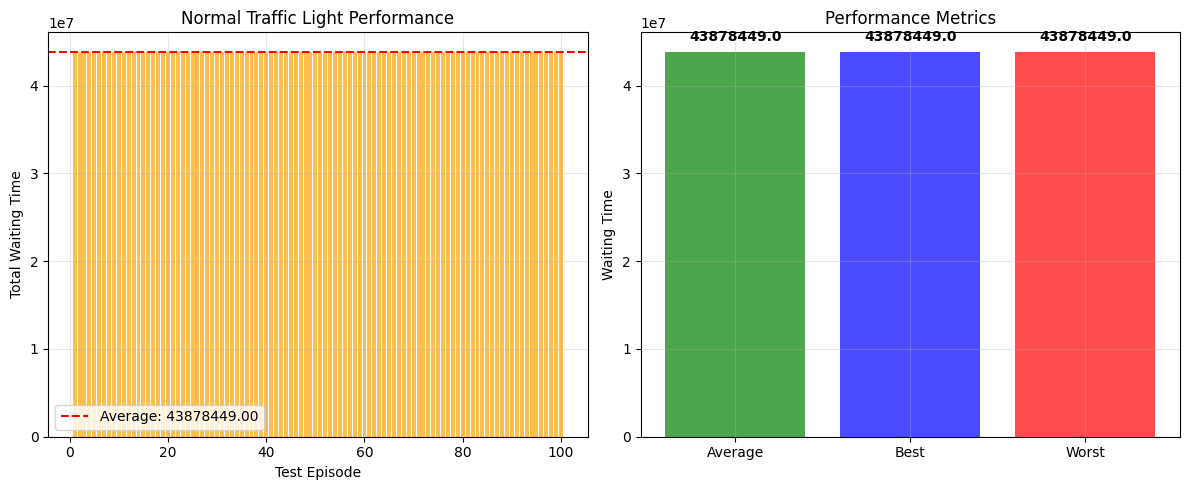

✅ Normal traffic baseline completed successfully!

==================== Training DQN ====================
🚀 Starting DQN training...
Parameters: epochs=100, steps=10000, model=traffic_comparison
📊 Network info: 8 junctions, max 5 lanes
🖥️  Device: cuda
Episode   1/100 - Total waiting time: 27857412.00 - Time:   70.2s
🎯 New best time: 27857412.00 - Saving best model...
Episode   2/100 - Total waiting time: 32468817.00 - Time:  139.3s
Episode   3/100 - Total waiting time: 32534736.00 - Time:  209.1s
Episode   4/100 - Total waiting time: 32375913.00 - Time:  278.4s
Episode   5/100 - Total waiting time: 30714648.00 - Time:  347.2s
Episode   6/100 - Total waiting time: 31578092.00 - Time:  417.8s
Episode   7/100 - Total waiting time: 31548445.00 - Time:  485.7s
Episode   8/100 - Total waiting time: 29879841.00 - Time:  554.5s
Episode   9/100 - Total waiting time: 31208550.00 - Time:  622.3s
Episode  10/100 - Total waiting time: 31786345.00 - Time:  692.5s
💾 Saved checkpoint at episode 10
Ep

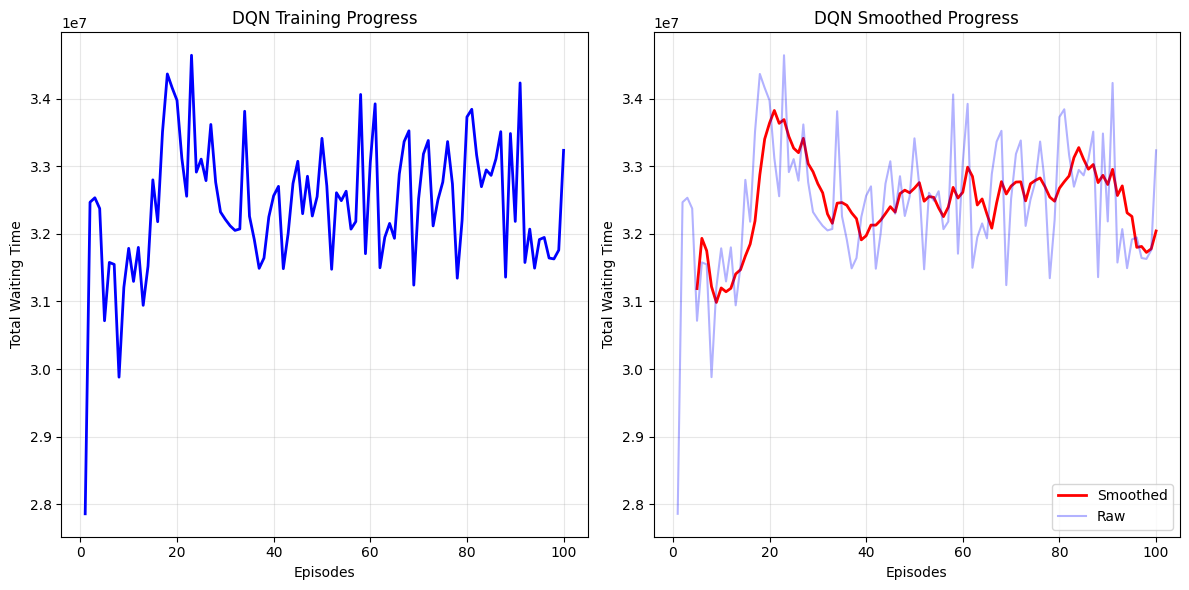


✅ DQN training completed!
📊 Best performance: 27857412.00 (episode 1)
⏱️  Total training time: 7460.7s (124.3min)
💾 Models saved as: traffic_comparison_dqn_best, traffic_comparison_dqn_final
✅ DQN training completed successfully!
💾 Best model saved: traffic_comparison_best

==================== Training PPO ====================
🚀 Starting PPO training...
Parameters: epochs=100, steps=10000, model=traffic_comparison
📊 Network info: 8 junctions, max 5 lanes
🖥️  Device: cuda
Episode   1/100 - Total waiting time: 14190167.00 - Time:   65.4s
🎯 New best time: 14190167.00 - Saving best model...
Episode   2/100 - Total waiting time: 16918243.00 - Time:  133.2s
Episode   3/100 - Total waiting time: 15760097.00 - Time:  198.6s
Episode   4/100 - Total waiting time: 18926368.00 - Time:  268.2s
Episode   5/100 - Total waiting time: 17094270.00 - Time:  334.6s
Episode   6/100 - Total waiting time: 19852528.00 - Time:  402.4s
Episode   7/100 - Total waiting time: 16590620.00 - Time:  471.0s
Episode 

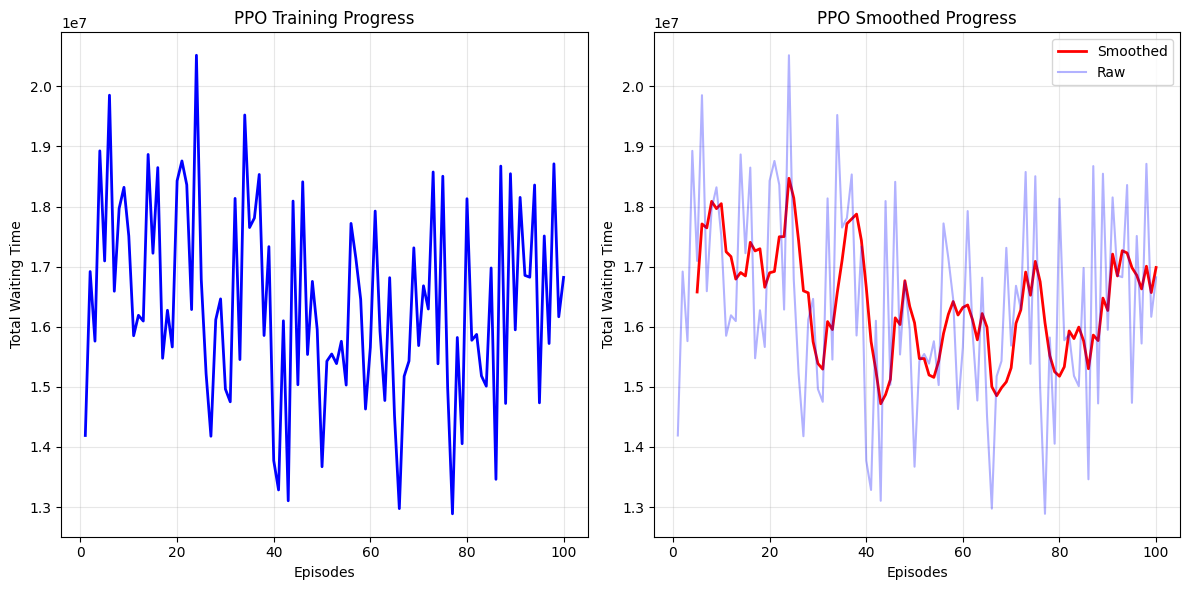


✅ PPO training completed!
📊 Best performance: 12887072.00 (episode 77)
⏱️  Total training time: 6431.9s (107.2min)
💾 Models saved as: traffic_comparison_ppo_best, traffic_comparison_ppo_final
✅ PPO training completed successfully!
💾 Best model saved: traffic_comparison_best

==================== Training A2C ====================
🚀 Starting A2C training...
Parameters: epochs=100, steps=10000, model=traffic_comparison
📊 Network info: 8 junctions, max 5 lanes
🖥️  Device: cuda
Episode   1/100 - Total waiting time: 17939000.00 - Time:   62.3s
🎯 New best time: 17939000.00 - Saving best model...
Episode   2/100 - Total waiting time: 13283847.00 - Time:  122.1s
🎯 New best time: 13283847.00 - Saving best model...
Episode   3/100 - Total waiting time: 14850919.00 - Time:  174.5s
Episode   4/100 - Total waiting time: 16833311.00 - Time:  226.7s
Episode   5/100 - Total waiting time: 13507762.00 - Time:  274.7s
Episode   6/100 - Total waiting time: 13477795.00 - Time:  322.8s
Episode   7/100 - Tot

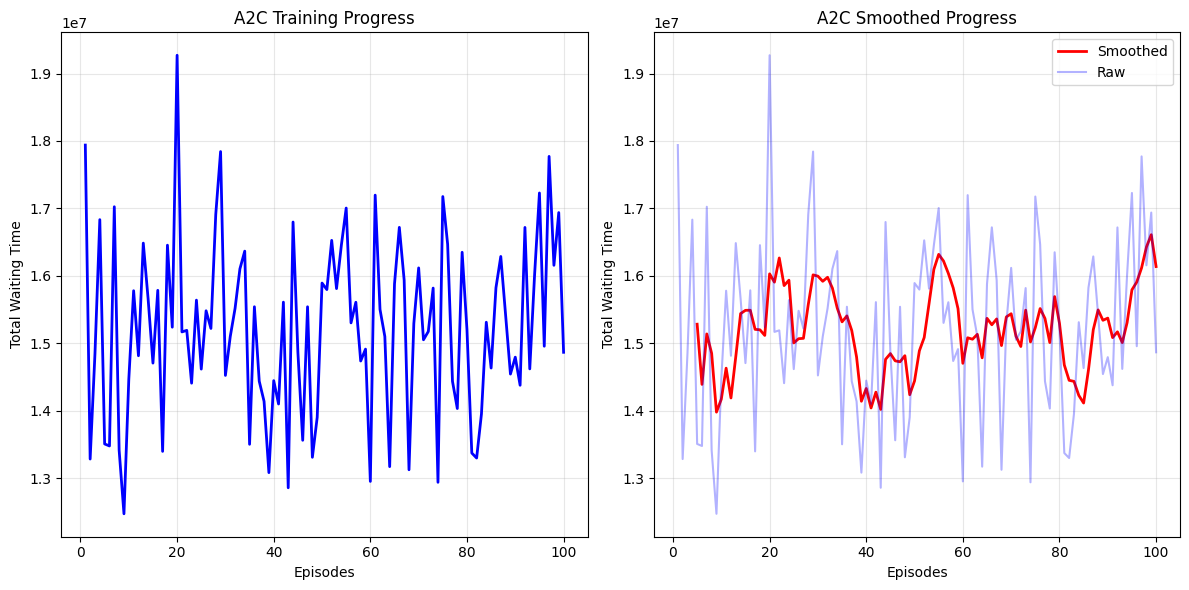


✅ A2C training completed!
📊 Best performance: 12471999.00 (episode 9)
⏱️  Total training time: 5131.2s (85.5min)
💾 Models saved as: traffic_comparison_a2c_best, traffic_comparison_a2c_final
✅ A2C training completed successfully!
💾 Best model saved: traffic_comparison_best

==================== Training SARSA ====================
🚀 Starting SARSA training...
Parameters: epochs=100, steps=10000, model=traffic_comparison
📊 Network info: 8 junctions, max 5 lanes
🖥️  Device: cuda
Episode   1/100 - Total waiting time: 24638591.00 - Time:   41.7s
🎯 New best time: 24638591.00 - Saving best model...
Episode   2/100 - Total waiting time: 22145304.00 - Time:   80.5s
🎯 New best time: 22145304.00 - Saving best model...
Episode   3/100 - Total waiting time: 24404983.00 - Time:  121.0s
Episode   4/100 - Total waiting time: 24672614.00 - Time:  161.1s
Episode   5/100 - Total waiting time: 25937405.00 - Time:  200.5s
Episode   6/100 - Total waiting time: 26987093.00 - Time:  242.1s
Episode   7/100 - T

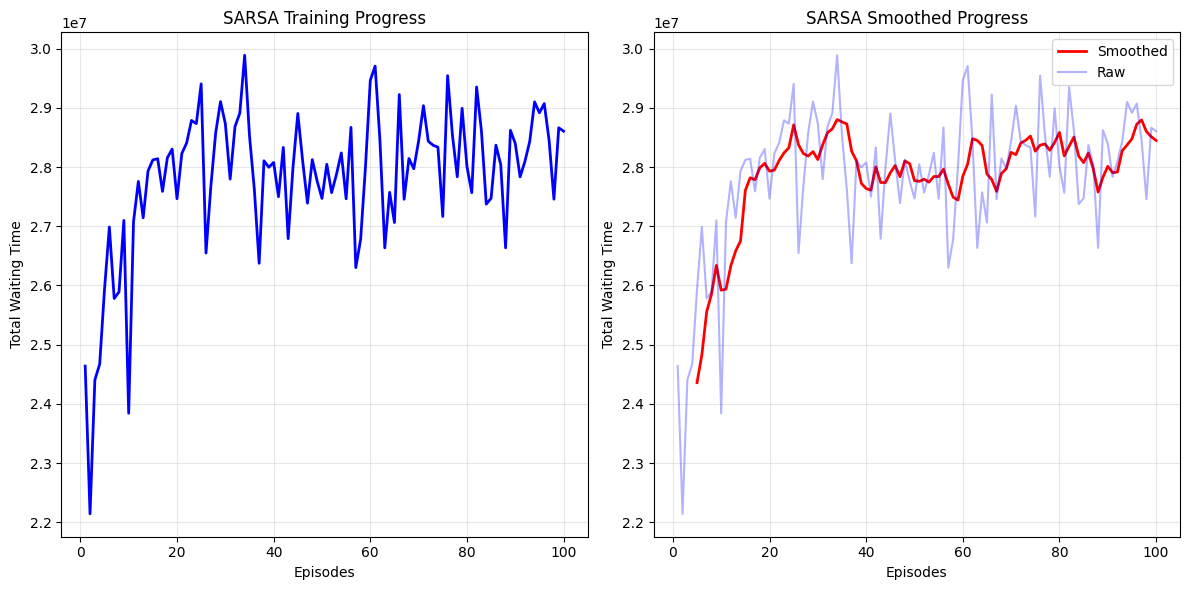


✅ SARSA training completed!
📊 Best performance: 22145304.00 (episode 2)
⏱️  Total training time: 4044.3s (67.4min)
💾 Models saved as: traffic_comparison_sarsa_best, traffic_comparison_sarsa_final
✅ SARSA training completed successfully!
💾 Best model saved: traffic_comparison_best

==================== COMPARISON RESULTS ====================


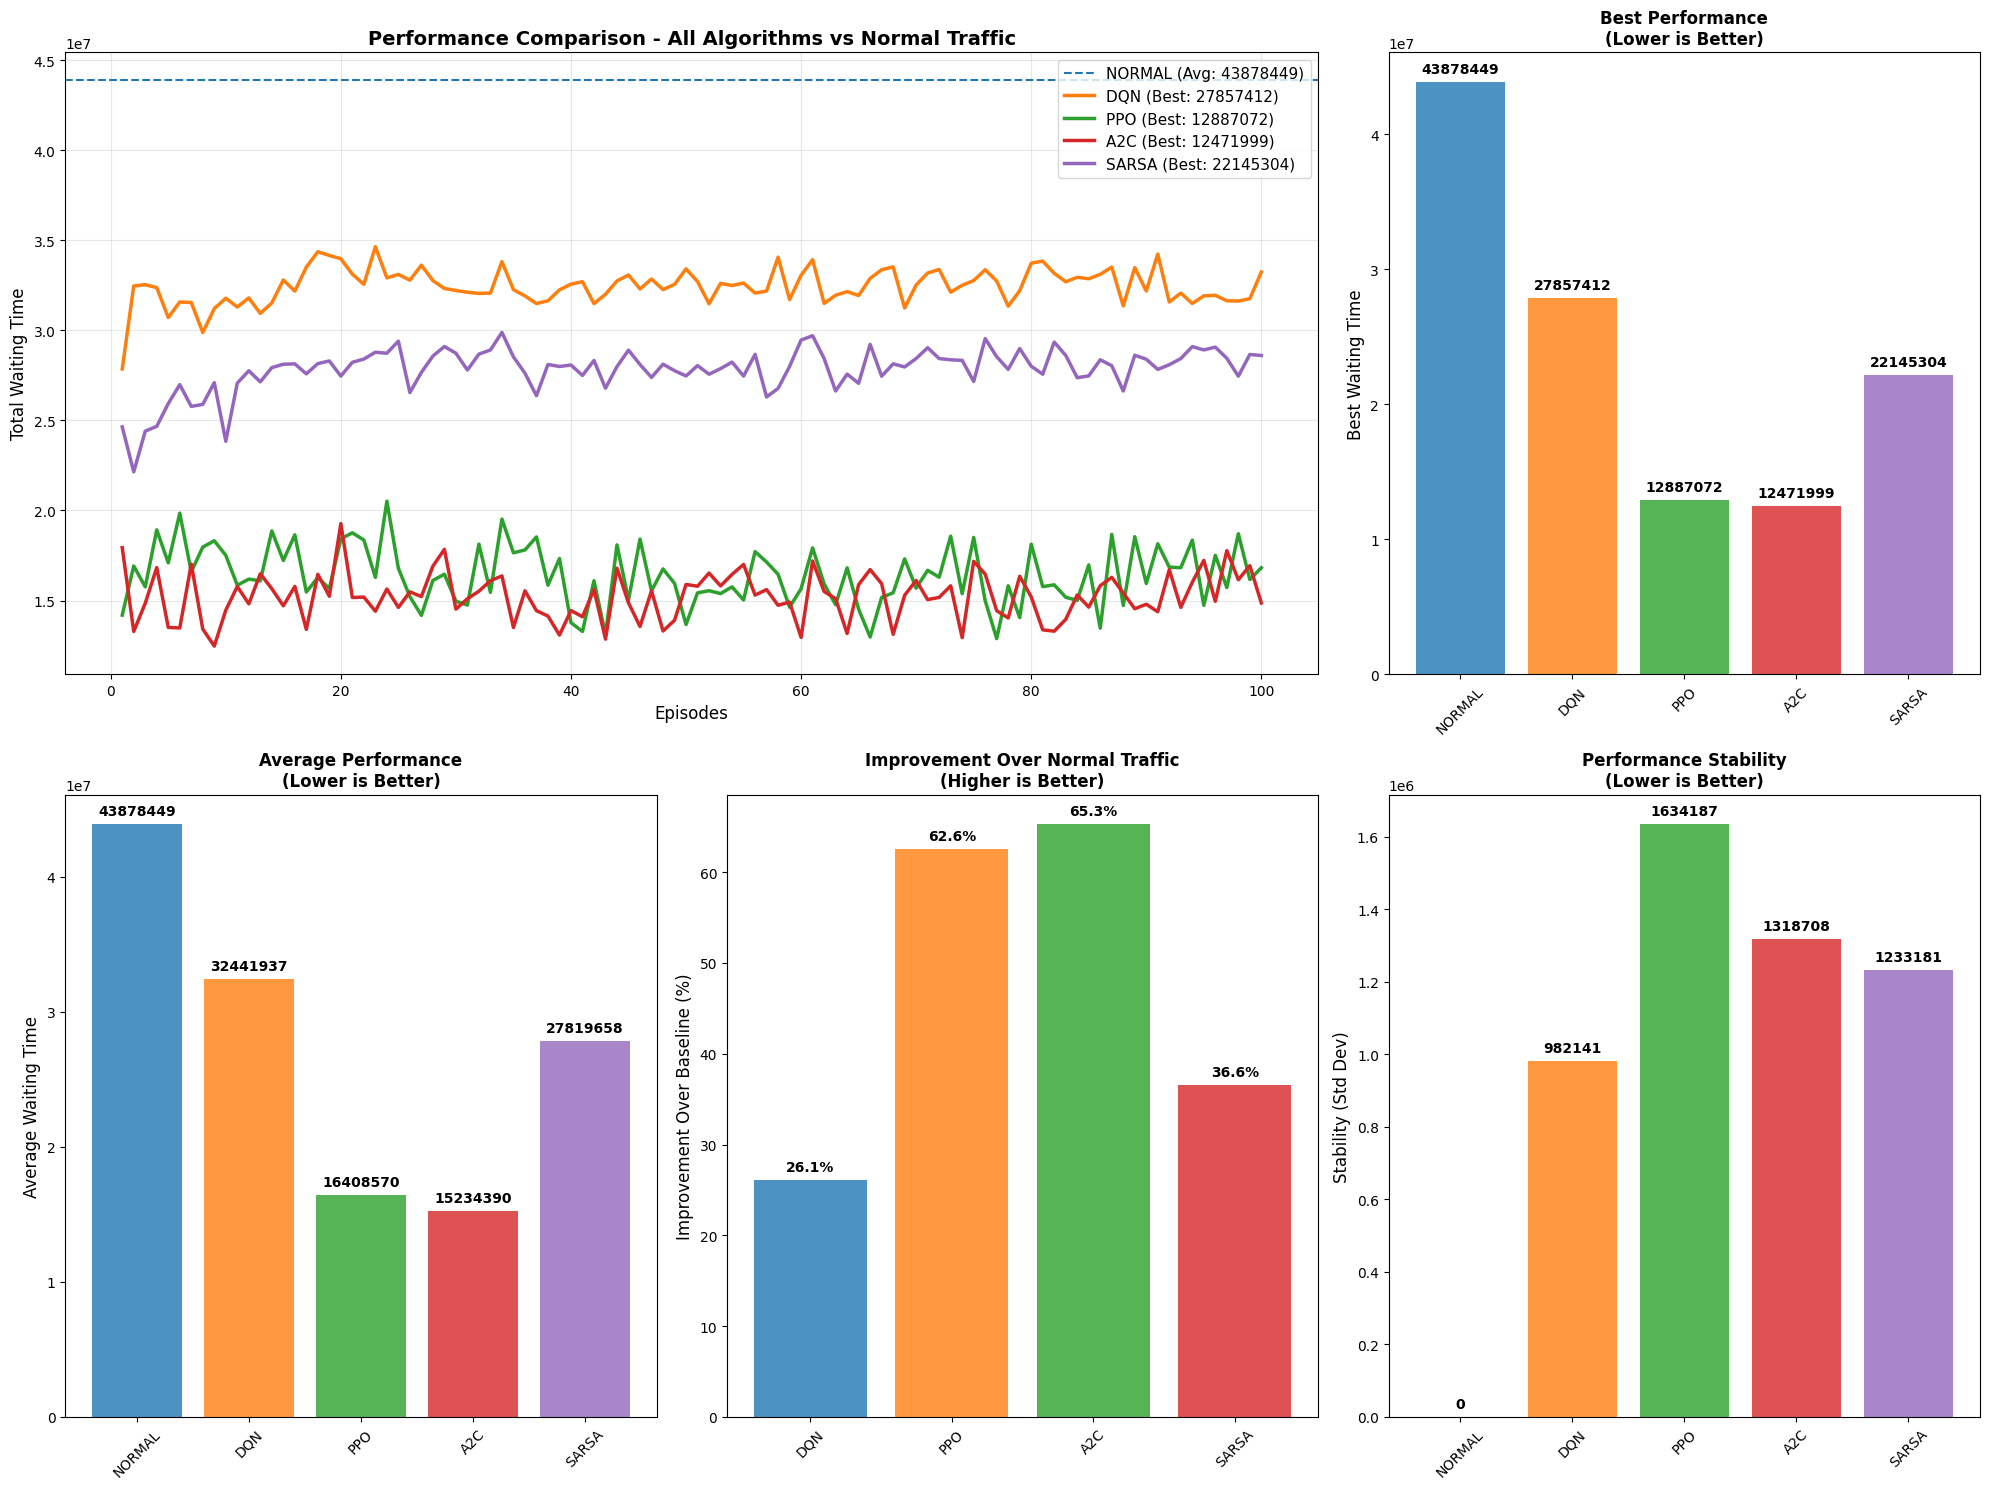


📊 FINAL COMPARISON SUMMARY:

🥇 Rank 1: A2C
   Best Performance: 12471999.00
   Average Performance: 15234389.89
   Training Time: 5131.2s
   Stability (Std Dev): 1318708.40
   Improvement over Normal: 65.3%
   💾 Best Model Path: models/a2c/traffic_comparison_best

🥈 Rank 2: PPO
   Best Performance: 12887072.00
   Average Performance: 16408569.51
   Training Time: 6431.9s
   Stability (Std Dev): 1634187.00
   Improvement over Normal: 62.6%
   💾 Best Model Path: models/ppo/traffic_comparison_best

🥉 Rank 3: SARSA
   Best Performance: 22145304.00
   Average Performance: 27819658.07
   Training Time: 4044.3s
   Stability (Std Dev): 1233180.64
   Improvement over Normal: 36.6%
   💾 Best Model Path: models/sarsa/traffic_comparison_best

#4 Rank 4: DQN
   Best Performance: 27857412.00
   Average Performance: 32441937.07
   Training Time: 7460.7s
   Stability (Std Dev): 982140.53
   Improvement over Normal: 26.1%
   💾 Best Model Path: models/dqn/traffic_comparison_best

#5 Rank 5: NORMAL
   B

In [ ]:
best_algo, results, models = compare_all_algorithms_with_baseline(
    model_name="traffic_comparison", 
    epochs=100, 
    steps=10000
) 

A2C Outperformed the rest because :

* Balance of Simplicity and Power: Unlike PPO, A2C is simpler but still captures policy + value, making it efficient in smaller, controlled tasks.

* Effective Credit Assignment: The advantage function helped it quickly learn which phases reduce waiting time most effectively.

* Lower Training Overhead: Shorter training time compared to PPO and DQN, while maintaining high stability.

* Consistency: Stable performance with low variance, unlike PPO which sometimes dipped.

## =======================================================================================

## Testing

🧪 Testing trained A2C model with normal traffic comparison
Parameters: episodes=5, steps=10000, GUI=False
🧪 Testing trained A2C model: traffic_comparison_best (best)
Parameters: episodes=5, steps=10000, GUI=False
📊 Network info: 8 junctions, max 5 lanes
✅ Model loaded successfully from 8 files!

Starting test episode 1/5...
Test Episode  1/5 - Total waiting time: 14355401.00

Starting test episode 2/5...
Test Episode  2/5 - Total waiting time: 15206719.00

Starting test episode 3/5...
Test Episode  3/5 - Total waiting time: 16182551.00

Starting test episode 4/5...
Test Episode  4/5 - Total waiting time: 18501596.00

Starting test episode 5/5...
Test Episode  5/5 - Total waiting time: 17250233.00

📈 TEST RESULTS SUMMARY:
Successful episodes: 5/5
Average Performance: 16299300.00
Best Performance: 14355401.00
Standard Deviation: 1465638.98
Consistency Score: 91.0%


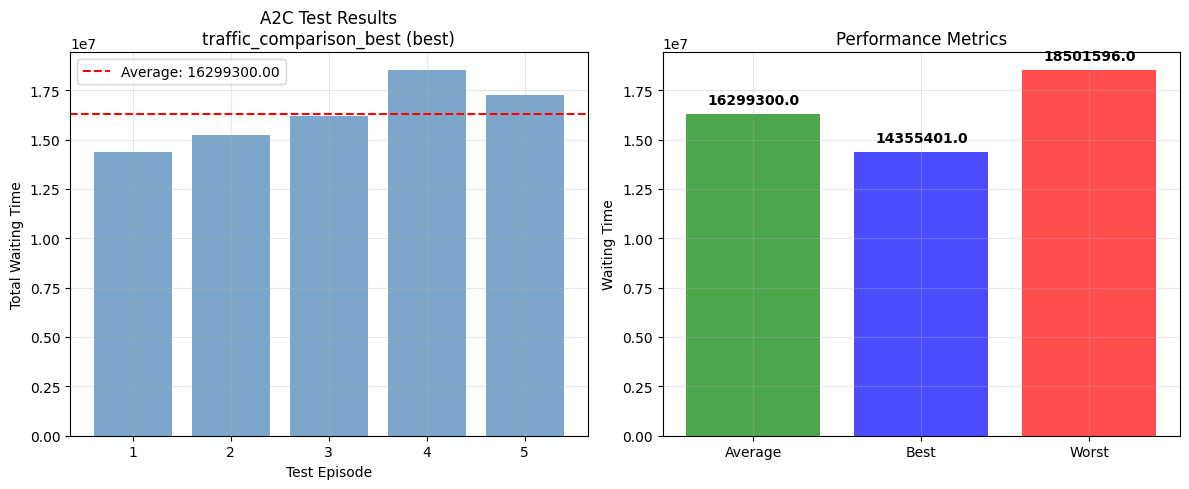


======================================== Testing Normal Traffic ========================================
🚦 Running normal traffic light operation
Parameters: episodes=5, steps=10000, GUI=False

Starting normal traffic episode 1/5...
Normal Episode  1/5 - Total waiting time: 43878449.00

Starting normal traffic episode 2/5...
Normal Episode  2/5 - Total waiting time: 43878449.00

Starting normal traffic episode 3/5...
Normal Episode  3/5 - Total waiting time: 43878449.00

Starting normal traffic episode 4/5...
Normal Episode  4/5 - Total waiting time: 43878449.00

Starting normal traffic episode 5/5...
Normal Episode  5/5 - Total waiting time: 43878449.00

📈 NORMAL TRAFFIC RESULTS SUMMARY:
Successful episodes: 5/5
Average Performance: 43878449.00
Best Performance: 43878449.00
Standard Deviation: 0.00
Consistency Score: 100.0%


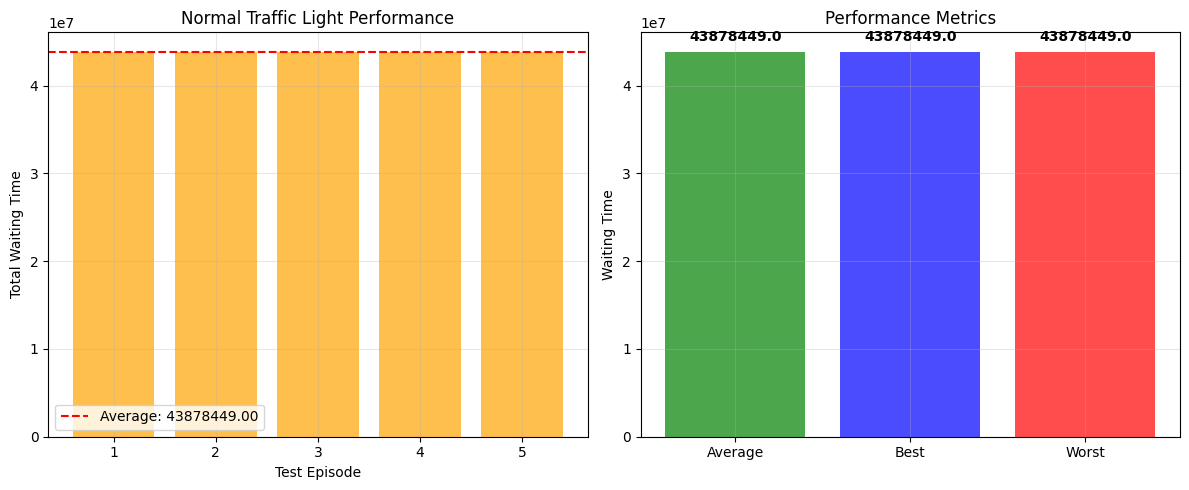


======================================== COMPARISON RESULTS ========================================
🧠 A2C Model Performance:
   Average Waiting Time: 16299300.00
   Best Performance: 14355401.00
   Standard Deviation: 1465638.98

🚦 Normal Traffic Performance:
   Average Waiting Time: 43878449.00
   Best Performance: 43878449.00
   Standard Deviation: 0.00

📈 Improvement over Normal Traffic: 62.85%


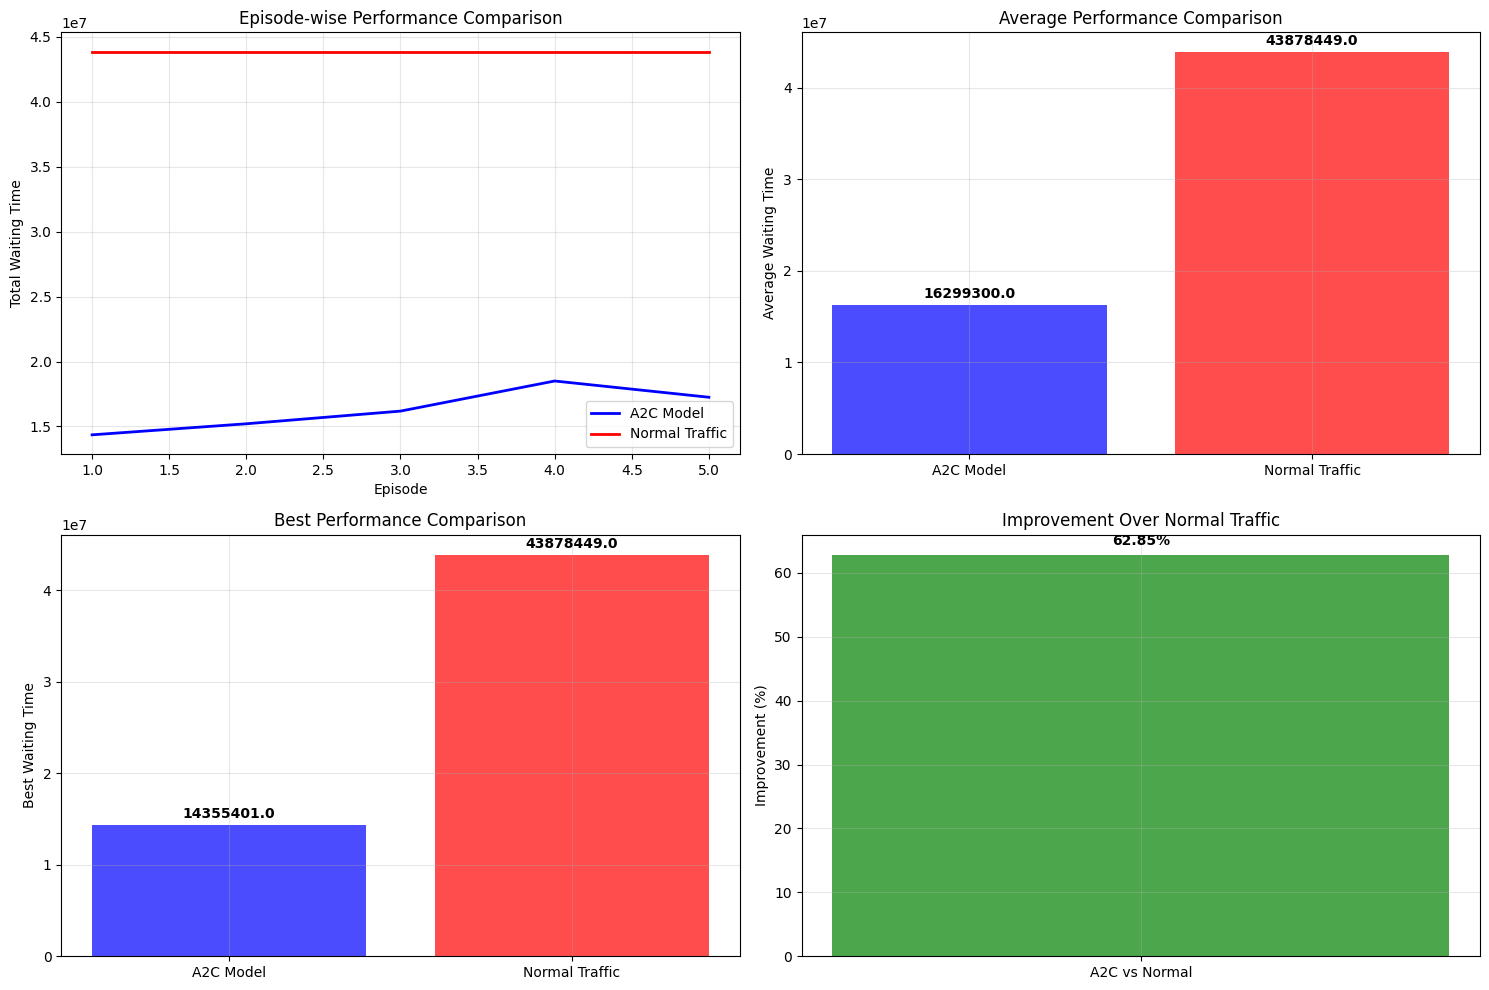

In [10]:
test_results = test_trained_model_with_normal_comparison(
    algorithm="A2C",
    model_name="traffic_comparison_best", 
    model_type="best",
    episodes=5,
    steps=10000,
    use_gui=False
)

# ======================================================

## Conclusion

* Among the evaluated methods, A2C emerged as the best overall, striking the right balance between learning efficiency, stability, and adaptability. 
* PPO also delivered strong results but required more training time and showed higher variability. 
* SARSA, though simple and tabular, performed surprisingly well as a baseline but lacks scalability for larger traffic networks. 
* DQN struggled with high-dimensional state spaces, resulting in unstable learning and the least improvement. Finally, the Normal setup performed worst, clearly demonstrating that reinforcement learning significantly enhances traffic flow optimization.

🧪 Testing trained A2C model with normal traffic comparison
Parameters: episodes=1, steps=10000, GUI=True
🧪 Testing trained A2C model: traffic_comparison_best (best)
Parameters: episodes=1, steps=10000, GUI=True
📊 Network info: 8 junctions, max 5 lanes
✅ Model loaded successfully from 8 files!

Starting test episode 1/1...
Test Episode  1/1 - Total waiting time: 15455150.00

📈 TEST RESULTS SUMMARY:
Successful episodes: 1/1
Average Performance: 15455150.00
Best Performance: 15455150.00
Standard Deviation: 0.00
Consistency Score: 100.0%


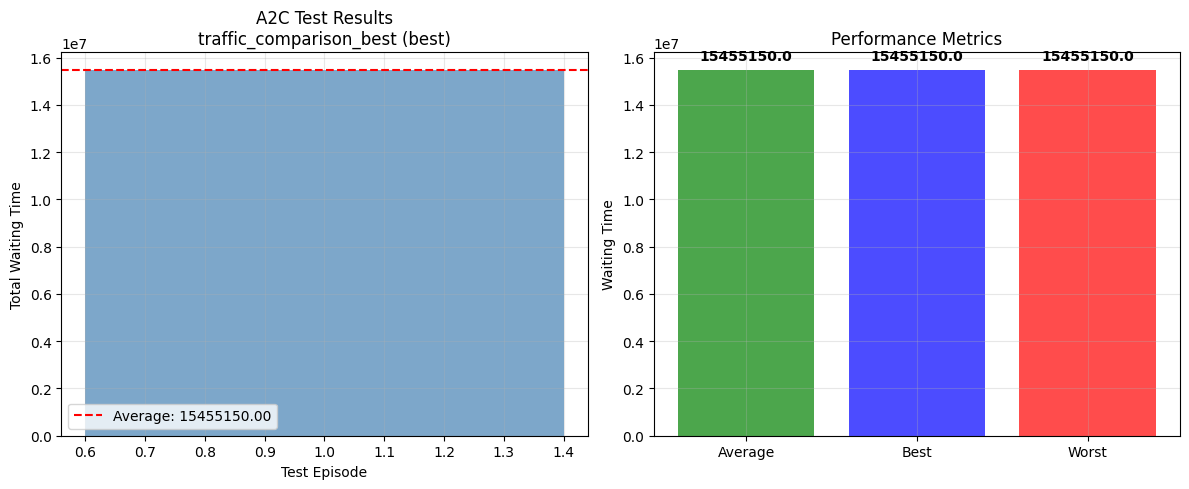


======================================== Testing Normal Traffic ========================================
🚦 Running normal traffic light operation
Parameters: episodes=1, steps=10000, GUI=True

Starting normal traffic episode 1/1...
Normal Episode  1/1 - Total waiting time: 43878449.00

📈 NORMAL TRAFFIC RESULTS SUMMARY:
Successful episodes: 1/1
Average Performance: 43878449.00
Best Performance: 43878449.00
Standard Deviation: 0.00
Consistency Score: 100.0%


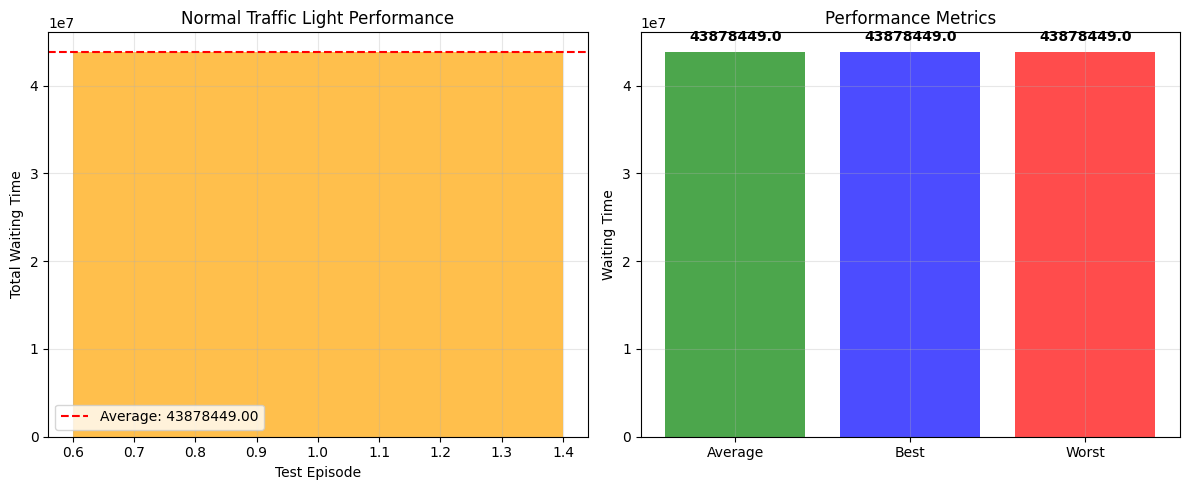


======================================== COMPARISON RESULTS ========================================
🧠 A2C Model Performance:
   Average Waiting Time: 15455150.00
   Best Performance: 15455150.00
   Standard Deviation: 0.00

🚦 Normal Traffic Performance:
   Average Waiting Time: 43878449.00
   Best Performance: 43878449.00
   Standard Deviation: 0.00

📈 Improvement over Normal Traffic: 64.78%


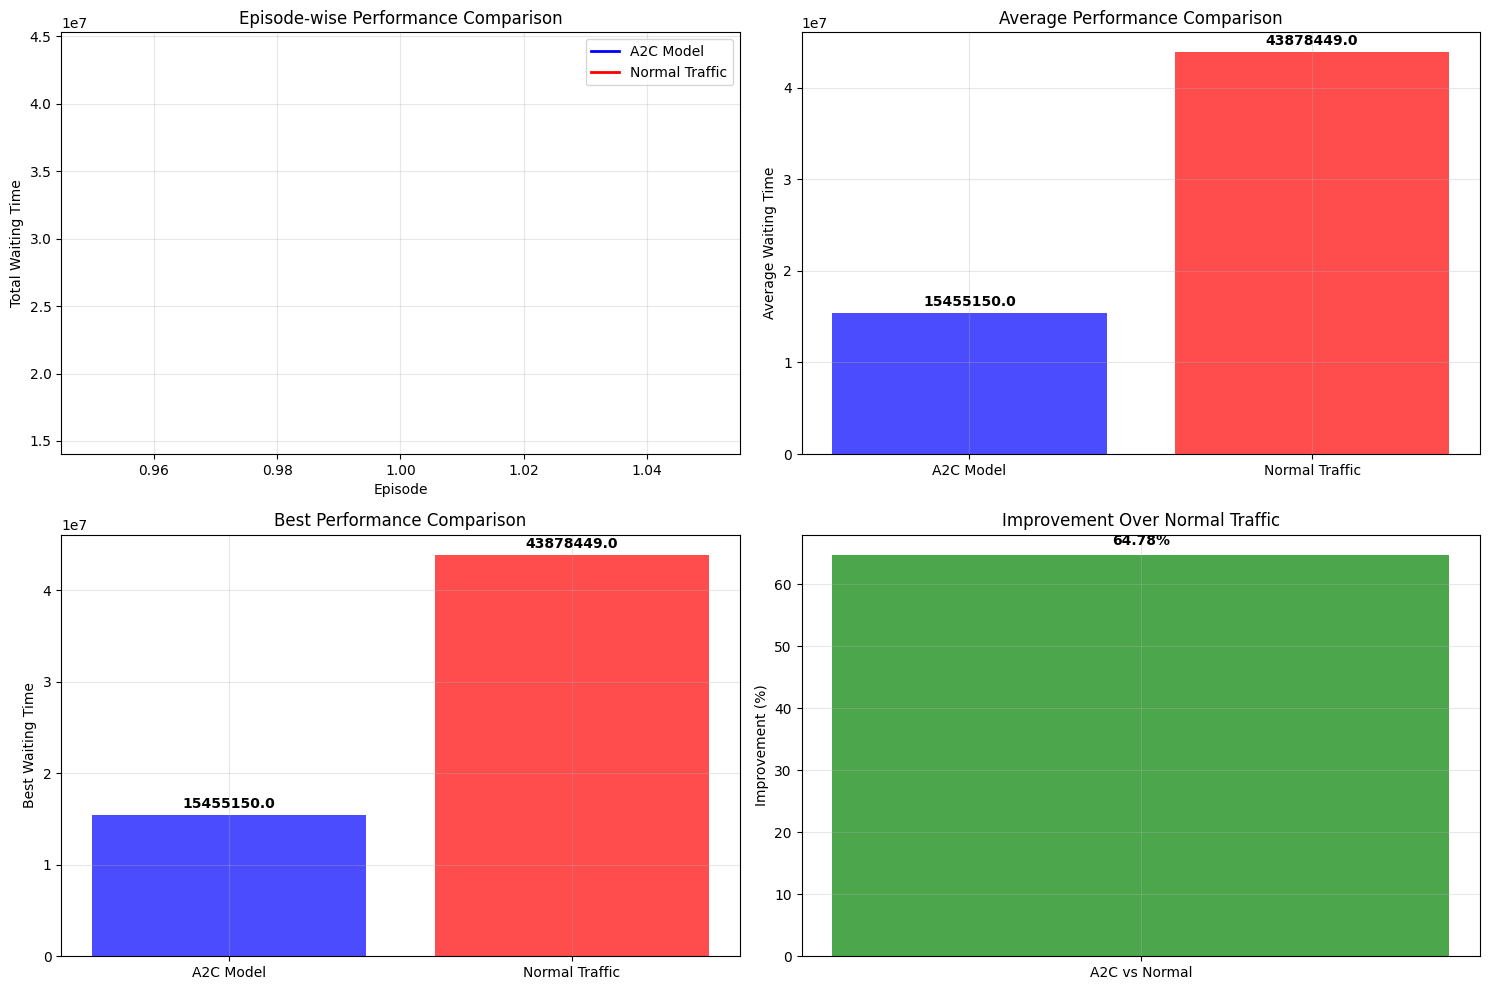

In [ ]:
test_results = test_trained_model_with_normal_comparison(
    algorithm="A2C",
    model_name="traffic_comparison_best", 
    model_type="best",
    episodes=1,
    steps=10000,
    use_gui=True
)